# Model the data to create nice visualisations for samples binned in $R, R_g$ and also in different bins of $|z|$

In [232]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')

import pathlib
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import gala.dynamics as gd
import gala.potential as gp
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torusimaging as oti
from astropy.constants import G
from gala.units import galactic
from pyia import GaiaData
from astropy.io import fits 
import tqdm
import cmasher as cm
import os
import model_radial

jax.config.update("jax_enable_x64", True)

In [233]:
# LOAD THE DATA
path = '/Users/dhortad/Documents/Data/allstar-dr17-StarHorse-Gaiadr3-astroNNages'
tb = fits.open(path)
data = tb[1].data 

# wmask = np.load('/Users/dhortad/Projects/Torusimaging-radial/sav/parent-mask-all.npy',allow_pickle=True)

wmask = np.load('/Users/dhortad/Projects/Torusimaging-radial/sav/parent-last.npy',allow_pickle=True)

print(len(data[wmask]))

68572


Define kinematic coords

In [234]:
import astropy.units as u
x = data['xyz'][:,0]
y = data['xyz'][:,1]
z = data['xyz'][:,2]
vx = data['vxyz'][:,0]
vy = data['vxyz'][:,1]
vz = data['vxyz'][:,2]
vz = (vz*u.km/u.s)
vz = vz.to(u.kpc/u.Gyr)
x = x*u.kpc
y = y*u.kpc
z = z*u.kpc

# Eilers rotation curve
Rgal = np.sqrt(data['xyz'][:,0]**2+data['xyz'][:,1]**2)
vcirc = 229.-1.7*(Rgal-8.275)
Rg = -(data['L'][:,2]/vcirc)
deltaR = Rgal-Rg
phi_deg = np.arctan(data['xyz'][:,1]/data['xyz'][:,0]) *(180./np.pi)
phi = np.arctan(data['xyz'][:,1]/data['xyz'][:,0])

#transform to cylindrical velocities
vR = +data['vxyz'][:,0]*np.cos(phi)+data['vxyz'][:,1]*np.sin(phi)
vt = -data['vxyz'][:,0]*np.sin(phi)+data['vxyz'][:,1]*np.cos(phi)

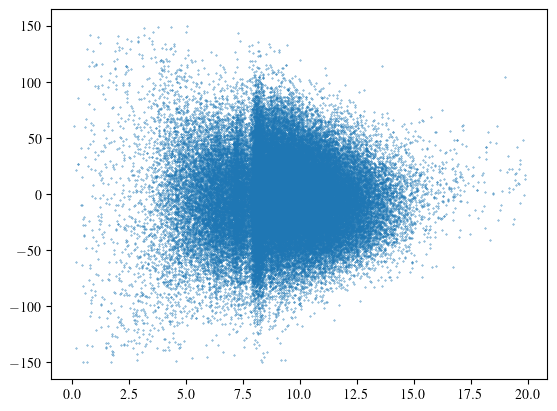

In [235]:
plt.scatter(Rgal[wmask], vR[wmask], s=0.1)

Define bins to grid data on in $R-v_R$

In [237]:
# create the bins to model the data in R-vR
nbins = 64
bins = {
    "pos": np.linspace(0, 16, nbins)*u.kpc,
    "vel": np.linspace(-100, 100, nbins)*u.km/u.s,
}

Bin the data using [Fe/H]

Initialise the model

In [238]:
x_param = Rgal * u.kpc
y_param = vR * u.km/u.s
label = data['FE_H']
label_err = data['FE_H_ERR']

# mask_kinematics = (np.abs(z)<)

bdata = oti.data.get_binned_label(
    pos=x_param[wmask].astype(np.float32),
    vel=y_param[wmask].astype(np.float32),
    label=label[wmask].astype(np.float32),
    label_err=label_err[wmask].astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=2,
)

In [239]:
model, bounds, init_params = model_radial.TorusImaging1DSpline.auto_init(
    bdata,
    label_knots=4,
    e_knots={2: 8, 4: 4},
    label_l2_sigma=1.0,
    label_smooth_sigma=0.5,
    e_l2_sigmas={2: 1.0, 4: 1.0},
    e_smooth_sigmas={2: 0.5, 4: 0.5},
    dacc_strength=1e2,
    e_knots_spacing_power=0.5,
)

# model, bounds, init_params = model_radial.TorusImaging1DSpline.auto_init(
#     bdata,
#     label_knots=4,
#     e_knots={1: 8, 3: 4},
#     label_l2_sigma=1.0,
#     label_smooth_sigma=0.5,
#     e_l2_sigmas={1: 1.0, 3: 1.0},
#     e_smooth_sigmas={1: 0.5, 3: 0.5},
#     dacc_strength=1e2,
#     e_knots_spacing_power=0.5,
# )


In [240]:
# init_params["e_params"][1]["vals"] = np.full_like(
#     init_params["e_params"][1]["vals"], np.log(0.1 / model._label_knots.max())
# )
init_params["e_params"][2]["vals"] = np.full_like(
    init_params["e_params"][2]["vals"], np.log(0.1 / model._label_knots.max())
)
# init_params["e_params"][3]["vals"] = np.full_like(
#     init_params["e_params"][3]["vals"], np.log(0.1 / model._label_knots.max())
# )
init_params["e_params"][4]["vals"] = np.full_like(
    init_params["e_params"][4]["vals"], np.log(0.01 / model._label_knots.max())
)

In [241]:
x_param = Rgal * u.kpc
y_param = vR * u.km/u.s
label = data['FE_H']
label_err = data['FE_H_ERR']

bdata = oti.data.get_binned_label(
    pos=x_param[wmask].astype(np.float32),
    vel=y_param[wmask].astype(np.float32),
    label=label[wmask].astype(np.float32),
    label_err=label_err[wmask].astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=2,
)

bdata_clean = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=bdata["label_err"],
)
bdata_mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

In [242]:
res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
res.state.success, res.state.iter_num

(True, 373)

Text(0, 0.5, '$v_R$ [$\\mathrm{km\\,s^{-1}}$]')

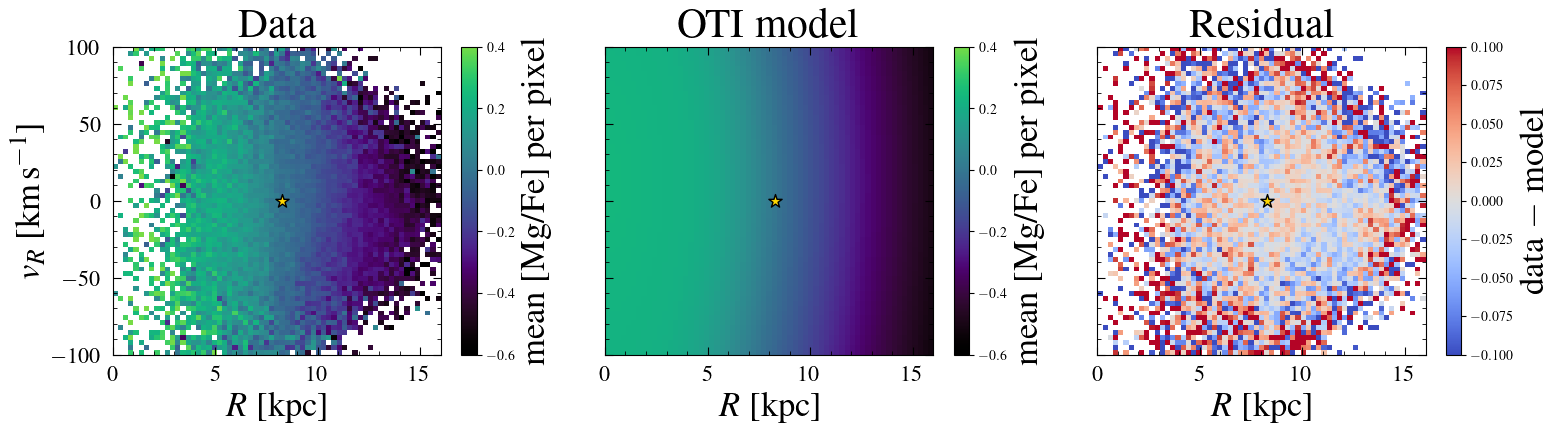

In [243]:
# visualise the data

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
# fig.suptitle(r'Low-$\alpha$ stars between $|z|<0.2$ kpc with $v_z<20$ km/s', fontsize=35, y=1.2)

ax = axes[0]
ax.set_title('Data', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"],
    vmin=-0.6,
    vmax=0.4,
    cmap=cm.lavender,
)
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Mg/Fe] per pixel", fontsize=25)
# props = dict(boxstyle='round', facecolor='white', alpha=1)
# ax.text(-1.75,-70, r'$8< R_{g} <9$ [kpc]', fontsize=18,
#     verticalalignment='top', bbox=props)
ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
# ax.set_ylim(-80,80)
# ax.set_xlim(-2.,2.)

ax = axes[1]
ax.set_title('OTI model', fontsize=30)
model_H = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    model_H,
    vmin=-0.6,
    vmax=0.4,
    cmap=cm.lavender
)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Mg/Fe] per pixel", fontsize=25)
ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
# ax.set_ylim(-80,80)
# ax.set_xlim(-2.,2.)

ax = axes[2]
ax.set_title('Residual', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"] - model_H,
    vmin=-0.1,
    vmax=0.1,
    cmap='coolwarm'
)

cb = fig.colorbar(cs, ax=ax)
cb.set_label("data $-$ model", fontsize=25)
ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
# ax.set_ylim(-80,80)
# ax.set_xlim(-2,2)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()

for ax in axes:
    ax.set_xlabel(f"$R$ [{u.kpc:latex_inline}]", fontsize=25)
axes[0].set_ylabel(f"$v_R$ [{u.km/u.s:latex_inline}]", fontsize=25)

# plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/model-data-Rg89kpc.pdf',dpi=250, bbox_inches = 'tight')


# Model as a function of $R$

Bin in non-overlapping guiding-centre radius bins

In [259]:
binsss = np.linspace(5.,15,11)*u.kpc
binsss

<Quantity [ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.] kpc>

In [256]:
# binsss = np.linspace(5,14,37)*u.kpc
# binsss 

In [260]:
acc_R = model.get_acceleration(binsss, res.params)
acc_R.shape

(11,)

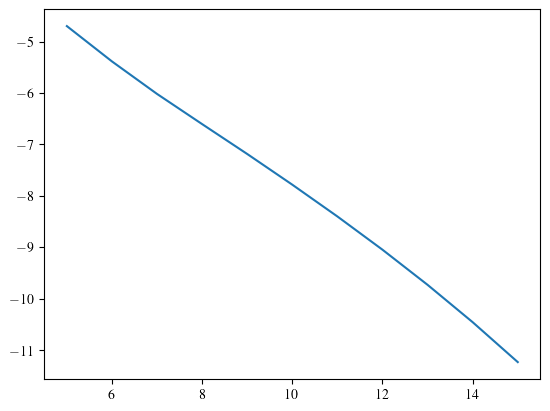

In [261]:
acc_ = acc_R.to(u.km/(u.s * u.Myr))
plt.plot(binsss.value, acc_.value)

In [264]:
acc_[3].value + 0.9

np.float64(-5.7047053518773065)

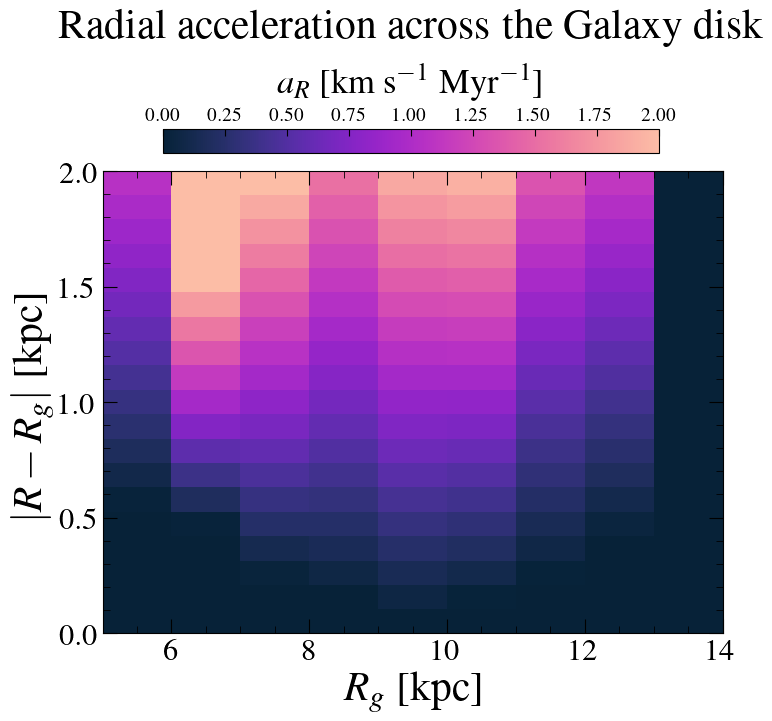

In [176]:

fig = plt.figure(figsize=(8,6),facecolor='white', rasterized=True)

fig.suptitle('Radial acceleration across the Galaxy disk',fontsize=30,x=0.51,y=1.15,rasterized=True)
plt.pcolormesh(
    binsss[:-1]+0.5,
    np.abs(bins_deltaR.value)+0.05,
    acc_R.T.value,
    shading="auto",
    cmap=cm.bubblegum,
    vmin=0,
    vmax=2,
)
plt.ylim(0,2)
# plt.xlim(5.5,13.5)
plt.xlabel(r'$R_g$ [kpc]',fontsize=30)
plt.ylabel(r'$|R-R_g|$ [kpc]',fontsize=30)
# plt.colorbar(label=r'$K_{z}$ [kpc Myr$^{-2}$]')
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=5, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.xlim(6,12)
# plt.ylim(0,1.3)
# plt.text(9.09,0.0,r'$\odot$',color='white',fontsize=30,weight="bold")
cbar_ax = fig.add_axes([0.2, 0.91, 0.62,0.04])
cb = plt.colorbar(cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'$a_{R}$ [km s$^{-1}$ Myr$^{-1}$]',fontsize=25,labelpad=10)
cb.ax.tick_params(labelsize=30)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=14,direction='in',top=True,right=True,length=5)
plt.tick_params(which='minor', length=3, direction='in',top=True,right=True)

# plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/acc-deltaR-R-z0poin2.pdf',dpi=250, bbox_inches = 'tight')


In [177]:
dens_R = np.zeros((len(res_bins), len(bins_deltaR)))
G_val = G.to(u.kpc**3/(u.solMass * u.Myr**2))
factor = 1./(4.*np.pi*G_val)
vc = 229.0 * u.km/u.s
vc = vc.to(u.kpc/u.Myr)

for indx, i in enumerate(res_bins):
    for jndx, j in enumerate(bins_deltaR):
        # freq = np.exp(i.params['ln_Omega0'])*(1./u.Myr)
        mask_bin = (Rg>binsss[indx])&(Rg<binsss[indx+1])&wmask&(np.abs(data['xyz'][:,2])<0.1)
        # radio = np.nanmean(Rgal[mask_bin])*(u.kpc)
        radio = (binsss[indx]+0.5)*(u.kpc)
        vel_circ = np.nanmean(vt[mask_bin])*(u.km/u.s)
        # vel_circ = vel_circ.to(u.kpc/u.Myr)
        momento_angular = radio*vel_circ
        momento_angular = radio*vc
        acc = acc_R[indx, jndx]
        dens_ = factor * (1./radio) * (acc + (momento_angular**2)/radio**3)
        dens_ = dens_.to(u.solMass/u.pc**3)
        dens_R[indx, jndx] = dens_.value

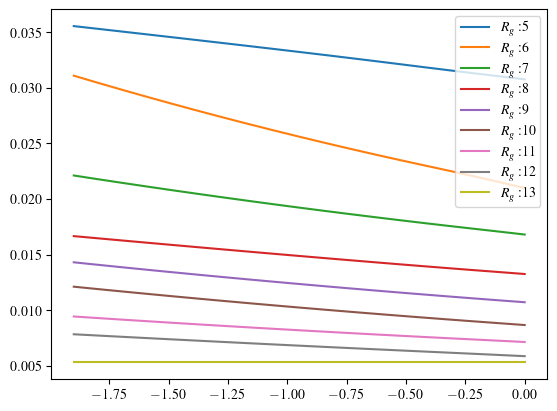

In [178]:
for jndx, j in enumerate(dens_R):
    plt.plot(bins_deltaR.value, j, label=r'$R_g:$'+str(round(binsss[jndx])))
plt.legend(loc='upper right')
# plt.yscale('log')
# plt.ylim(-10,10)

In [107]:
dens_R = dens_R * (u.solMass/(u.kpc**3))
dens_R = dens_R.to(u.solMass/u.pc**3)

In [83]:
# dens_R = dens_R * (u.kg * u.s**2)/(u.Myr**2 * u.m**3)
# dens_R = dens_R.to(u.solMass/u.pc**3)

In [73]:
bins_deltaR = np.linspace(0.,2.,21)*u.kpc
bins_deltaR

<Quantity [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
           1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ] kpc>

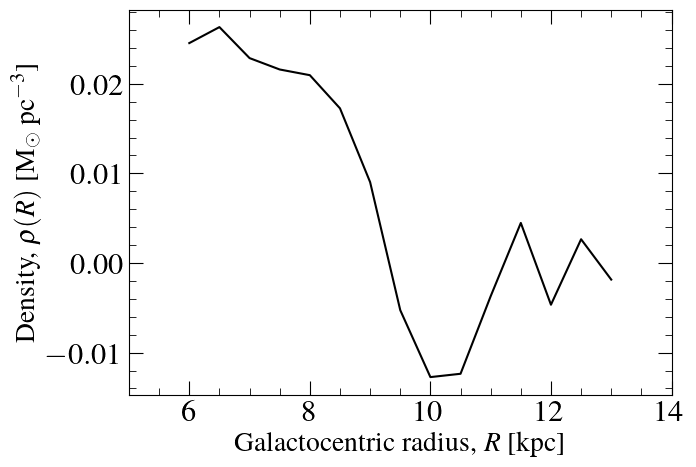

In [85]:
plt.figure(figsize=(7,5))
# plt.plot(Rs+1, dens_pos, lw=2, ls='dotted', color='k')
plt.plot(binsss[:-2]+1, dens_R, color='k')
plt.xlim(5,14)
# plt.ylim(1e-4,0.15)
# plt.yscale('log')
# plt.errorbar(8.275, 0.081, yerr = 0.0015, color='r', capsize=5)
plt.xlabel('Galactocentric radius, $R$ [kpc]', fontsize=20)
plt.ylabel(r'Density, $\rho(R)$ [M$_{\odot}$ pc$^{-3}$]', fontsize=20)
plt.legend(loc='upper right', frameon=False, ncols=2, fontsize=12)
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=5, direction='in',top=True,right=True)
plt.minorticks_on()

# plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/dens-z0point2.pdf',dpi=250, bbox_inches = 'tight')


In [112]:
dvc_dR_ = np.zeros((len(res_bins), len(rminusrg_bins)))
vc = 229.0 
dvc_dR_pos = np.zeros((len(res_bins)))

for indx, i in enumerate(res_bins):
    dvc_dR_pos[indx] = (-np.abs(i.params['pos0'])*freq**2)/(2.*vc)
    for jndx, j in enumerate(rminusrg_bins):
        freq = np.exp(i.params['ln_Omega0'])
        dvc_dR = (-np.abs(j)*freq**2)/(2.*vc)
        dvc_dR_[indx, jndx] = dvc_dR

In [113]:
dvc_dR_ = dvc_dR_*(u.kpc * u.s)/(u.km * u.Myr**2)
dvc_dR_ = dvc_dR_.to(u.km/(u.s * u.kpc))
dvc_dR_pos = dvc_dR_pos*(u.kpc * u.s)/(u.km * u.Myr**2)
dvc_dR_pos = dvc_dR_pos.to(u.km/(u.s * u.kpc))
dvc_dR_pos.shape, dvc_dR_.shape

((15,), (15, 19))

In [114]:
vcs = np.zeros((dvc_dR_.shape[0], 10))
vcs_pos = np.zeros((dvc_dR_pos.shape))
for indx, i in enumerate(dvc_dR_[:,:10]):
    vcs_pos[indx] = 229.0 + res_bins[indx].params['pos0']*(Rs[indx]+1 - 8.275)
    for jndx, j in enumerate(i):
        vcs[indx, jndx] = 229.0 + j.value*(Rs[indx]+1 - 8.275)


In [115]:
colores = ['indigo', 'rebeccapurple', 'purple', 'darkorchid', 'mediumorchid', 'magenta', 'violet', 'hotpink','plum', 'lightpink']

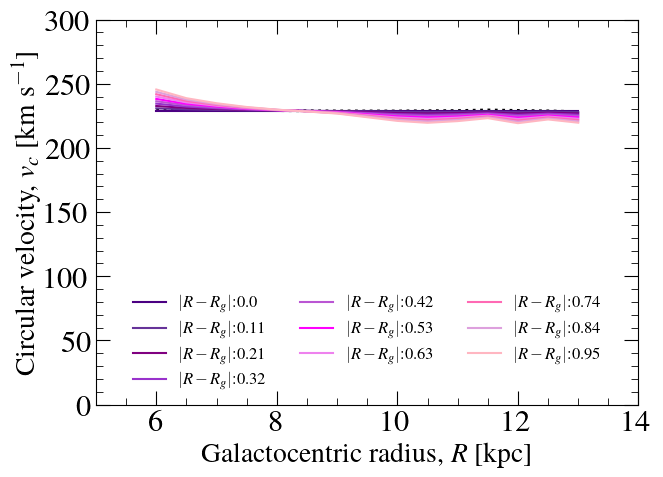

In [116]:
plt.figure(figsize=(7,5))
plt.plot(Rs+1, vcs_pos, lw=2, ls='dotted', color='k')
for indx, i in enumerate(vcs.T):
    plt.plot(Rs+1, i, label='$|R-R_g|$:'+str(np.abs(round(rminusrg_bins[indx],2))), color=colores[indx])
plt.xlim(5,14)
plt.ylim(0,300)
plt.xlabel('Galactocentric radius, $R$ [kpc]', fontsize=20)
plt.ylabel('Circular velocity, $v_c$ [km s$^{-1}$]', fontsize=20)
plt.legend(loc='lower center', frameon=False, ncols=3, fontsize=12)
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=5, direction='in',top=True,right=True)
plt.minorticks_on()

# plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/vcirc-z0point2.pdf',dpi=250, bbox_inches = 'tight')


In [80]:
for jndx, j in enumerate(res_bins):
    print(j.params['pos0'])

0.09319519445282372
-0.19525660525205701
-0.3248950643591109
-0.15319790084625773
-0.07492170802309454
0.051916150569007675
-0.03669513874352646
-0.013096326840494674
-0.56399420971934


In [118]:
dens_ = dens_ * ((u.kg * u.s**2)/(u.Myr**2 * u.m**3))
dens_ = dens_.to(u.solMass/u.pc**3)
dens_pos = dens_pos * ((u.kg * u.s**2)/(u.Myr**2 * u.m**3))
dens_pos = dens_pos.to(u.solMass/u.pc**3)
dens_pos.shape, dens_.shape

((15,), (15, 10))

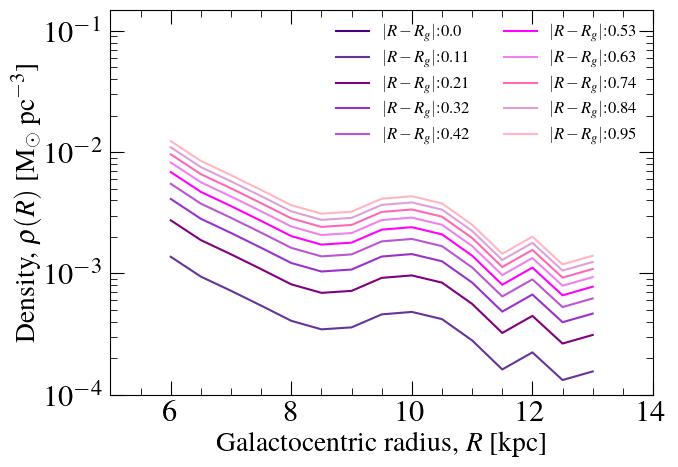

In [119]:
plt.figure(figsize=(7,5))
# plt.plot(Rs+1, dens_pos, lw=2, ls='dotted', color='k')
for indx, i in enumerate(dens_.T):
    plt.plot(Rs+1, i, label='$|R-R_g|$:'+str(np.abs(round(rminusrg_bins[indx],2))), color=colores[indx])
plt.xlim(5,14)
plt.ylim(1e-4,0.15)
plt.yscale('log')
# plt.errorbar(8.275, 0.081, yerr = 0.0015, color='r', capsize=5)
plt.xlabel('Galactocentric radius, $R$ [kpc]', fontsize=20)
plt.ylabel(r'Density, $\rho(R)$ [M$_{\odot}$ pc$^{-3}$]', fontsize=20)
plt.legend(loc='upper right', frameon=False, ncols=2, fontsize=12)
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=5, direction='in',top=True,right=True)
plt.minorticks_on()

plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/dens-z0point2.pdf',dpi=250, bbox_inches = 'tight')


In [141]:
Rgs = np.linspace(5,12,15)

dens__ = []
vc = 229.*u.km/u.s
vc = vc.to(u.kpc/u.Myr)
grav = G
grav = grav.to(u.kpc**3/(u.solMass*u.Myr**2))

for indx, i in enumerate(res_bins):
    freq = np.exp(i.params['ln_Omega0'])
    dens__.append(-(freq**2 - (3.*vc.value**2)/(Rgs[indx]))/(4.*np.pi*grav.value))


In [143]:
dens__ = dens__ * (u.solMass/u.kpc**3)
dens__ = dens__.to(u.solMass/u.pc**3)
dens__

<Quantity [0.51723367, 0.48025341, 0.444312  , 0.41445688, 0.38891161,
           0.36357129, 0.33667682, 0.30548529, 0.28241968, 0.26864897,
           0.26456349, 0.26118301, 0.24137688, 0.23875338, 0.22491813] solMass / pc3>

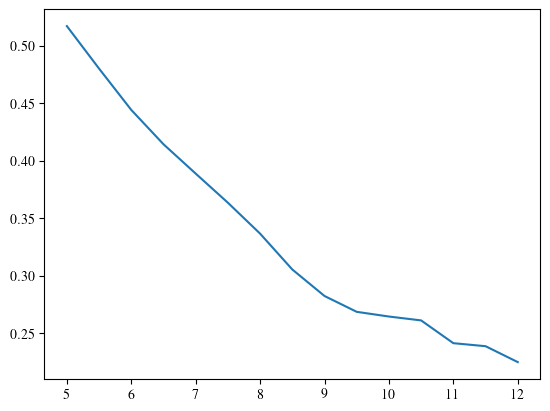

In [144]:
plt.plot(Rgs, dens__)

Now also bin in $\phi$

380
671
968
1381
1699
1824
1925
1768
1615
1298
914
606
379


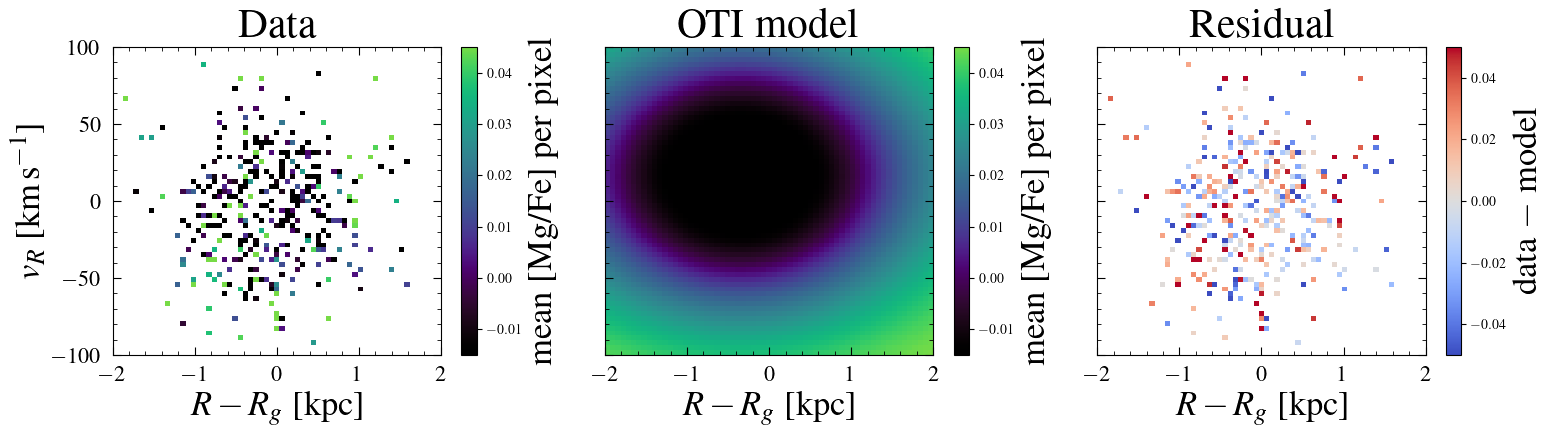

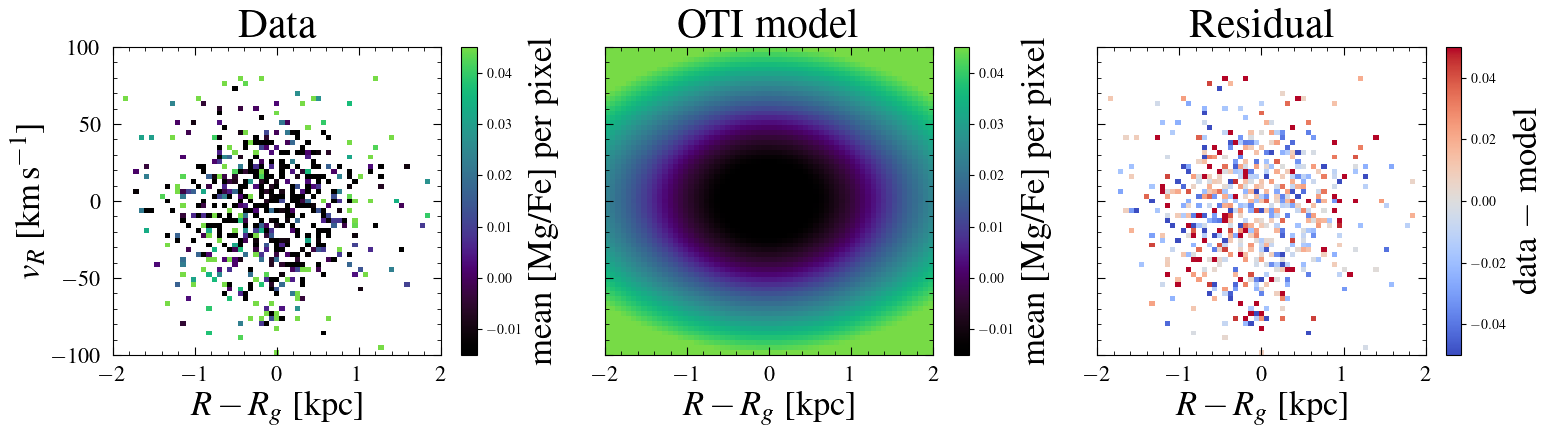

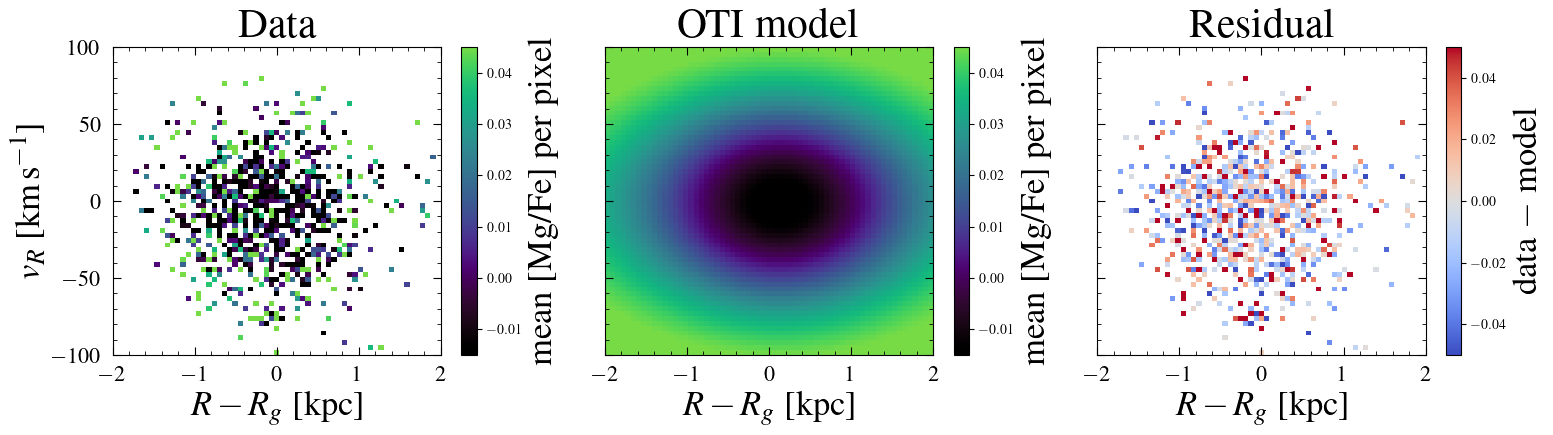

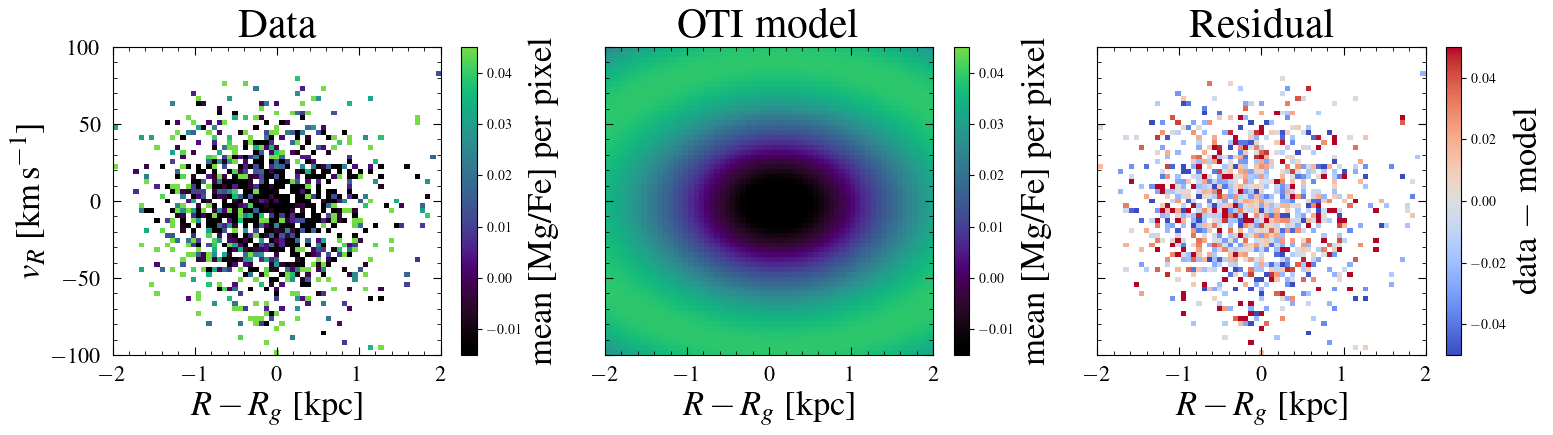

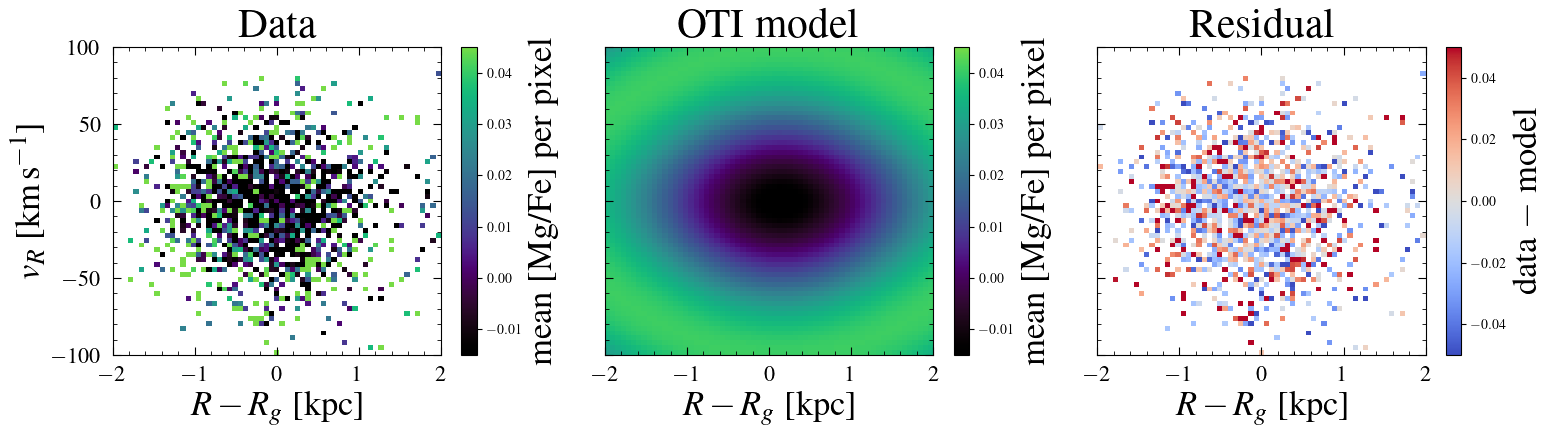

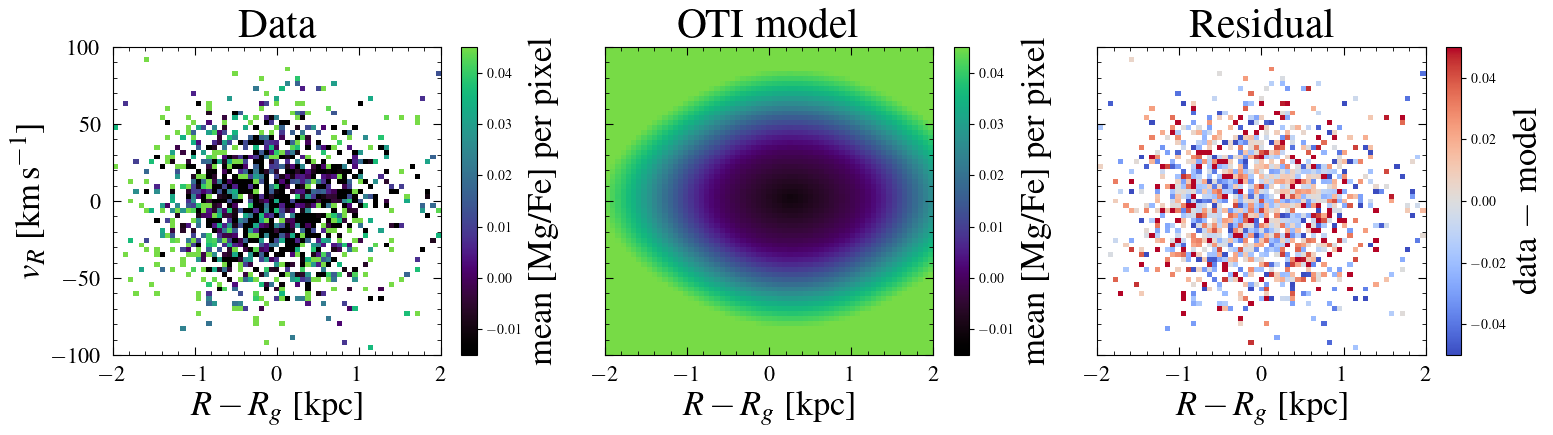

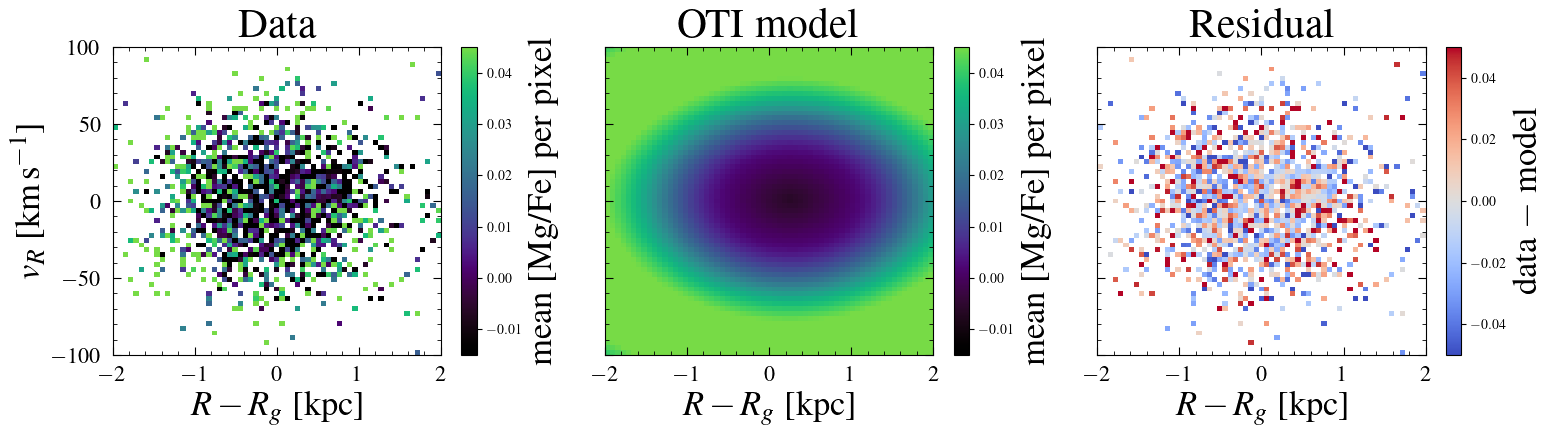

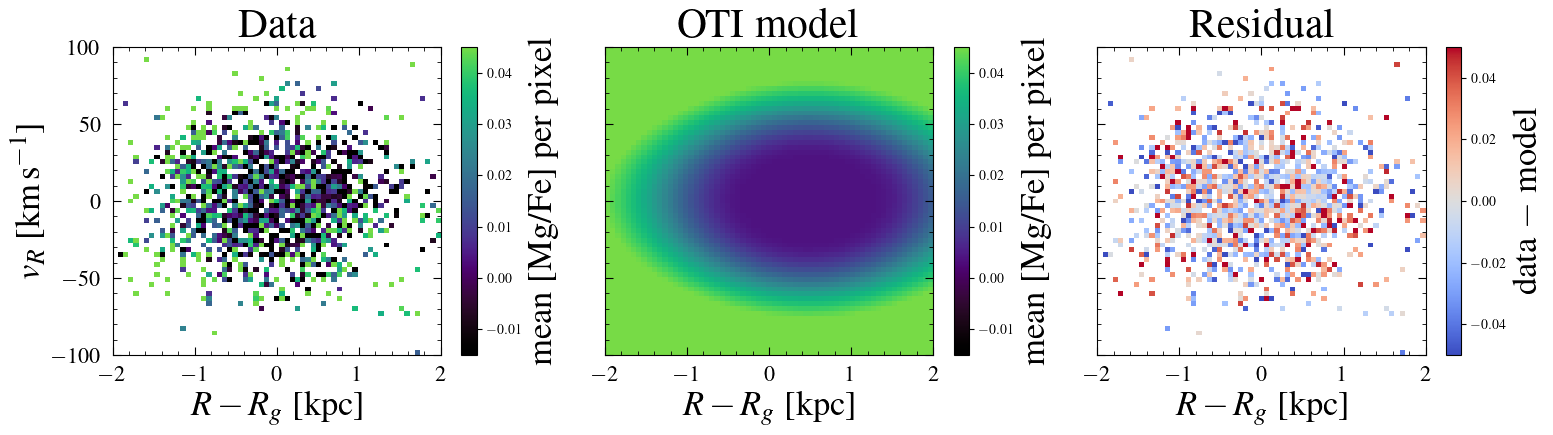

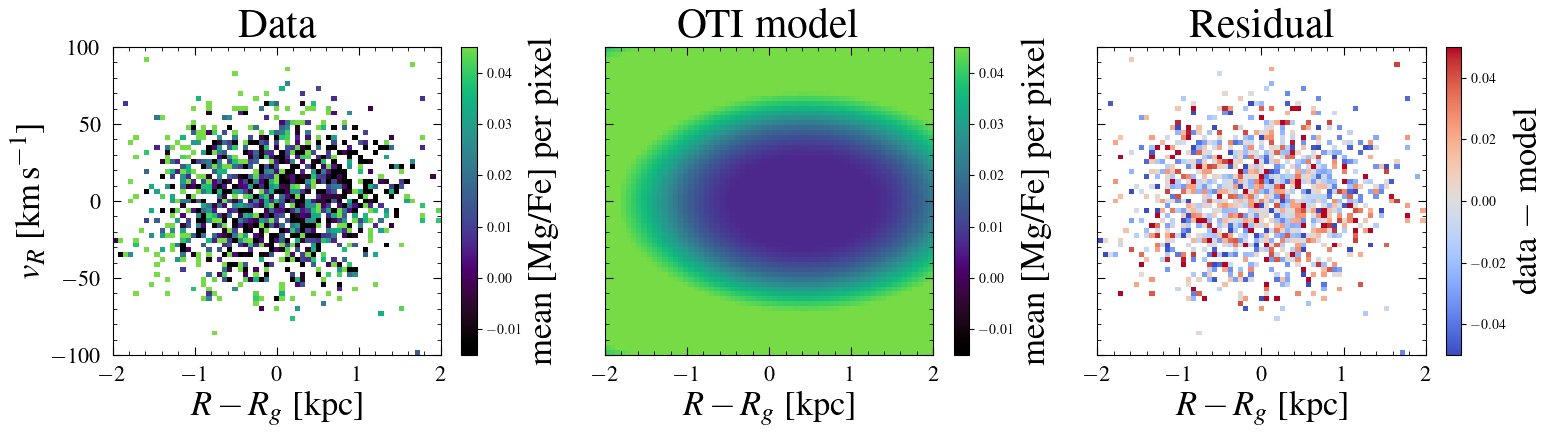

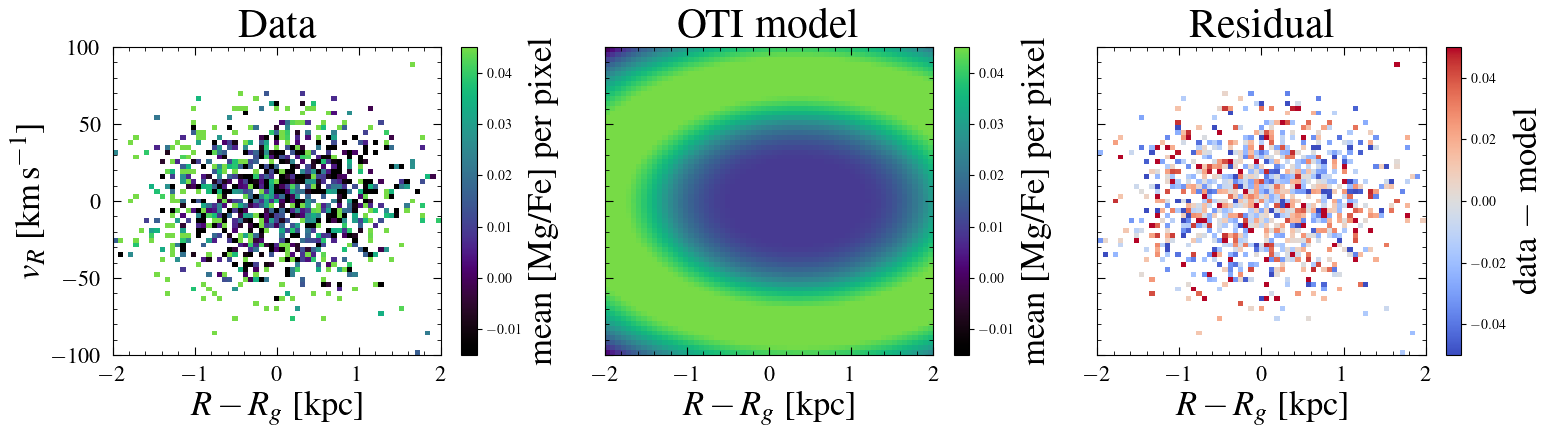

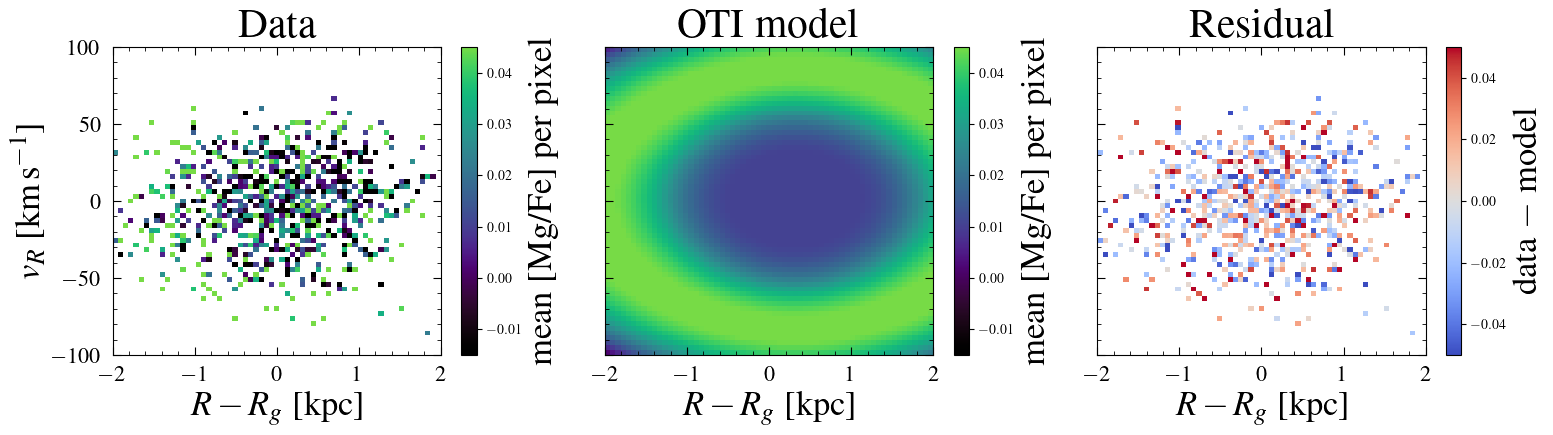

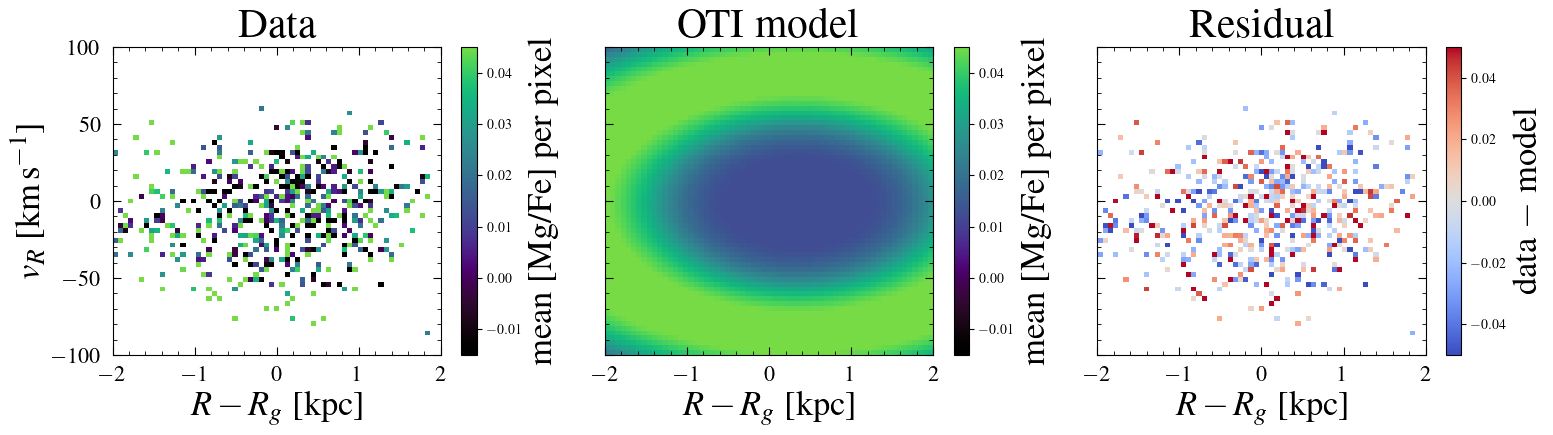

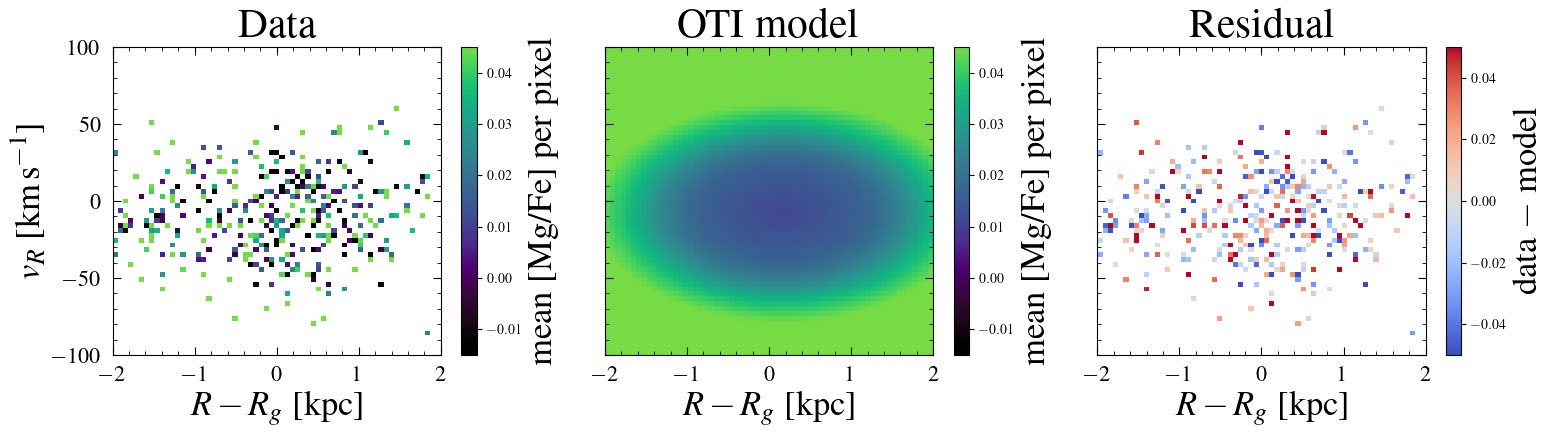

In [35]:
binsss = np.linspace(5,12,15)
bdata_clean_bins = []
res_bins_phi1 = []

for indx, i in enumerate(binsss[:-2]):
    mask_bin = (Rgal>i)&(Rgal<i+2)&wmask&(phi_deg<-10)
    print(len(Rgal[mask_bin]))
    bdata_clean_bins_, res_bins_ = get_bins_plot(x_param, y_param, label, label_err, mask_bin)
    bdata_clean_bins.append(bdata_clean_bins_)
    res_bins_phi1.append(res_bins_)

In [36]:
rminusrg_bins = np.linspace(-1.9,1.9,19)
acc_R_phi1 = np.zeros((len(res_bins_phi1), len(rminusrg_bins)))

for indx, i in enumerate(res_bins_phi1):
    for jndx, j in enumerate(rminusrg_bins):
        freq = np.exp(i.params['ln_Omega0'])
        acc_ = -j * freq**2
        acc_R_phi1[indx, jndx] = acc_

In [37]:
acc_R_phi1 = acc_R_phi1*u.kpc/u.Myr**2
acc_R_phi1 = acc_R_phi1.to(u.km/(u.s * u.Myr))

In [40]:
Rs = np.linspace(5,12,15)
dens_phi1 = np.zeros((len(res_bins_phi1), 10))
vc = 229.0 
dens_pos = np.zeros((len(res_bins_phi1)))

for indx, i in enumerate(res_bins_phi1):
    freq = np.exp(i.params['ln_Omega0'])
    for jndx, j in enumerate(rminusrg_bins[:10]):
        dens = (np.abs(j)*freq**2)/(4.*np.pi*G.value*Rs[indx])
        dens_phi1[indx, jndx] = dens

622
745
869
1944
2408
2936
3313
2627
2420
2083
1741
1355
984


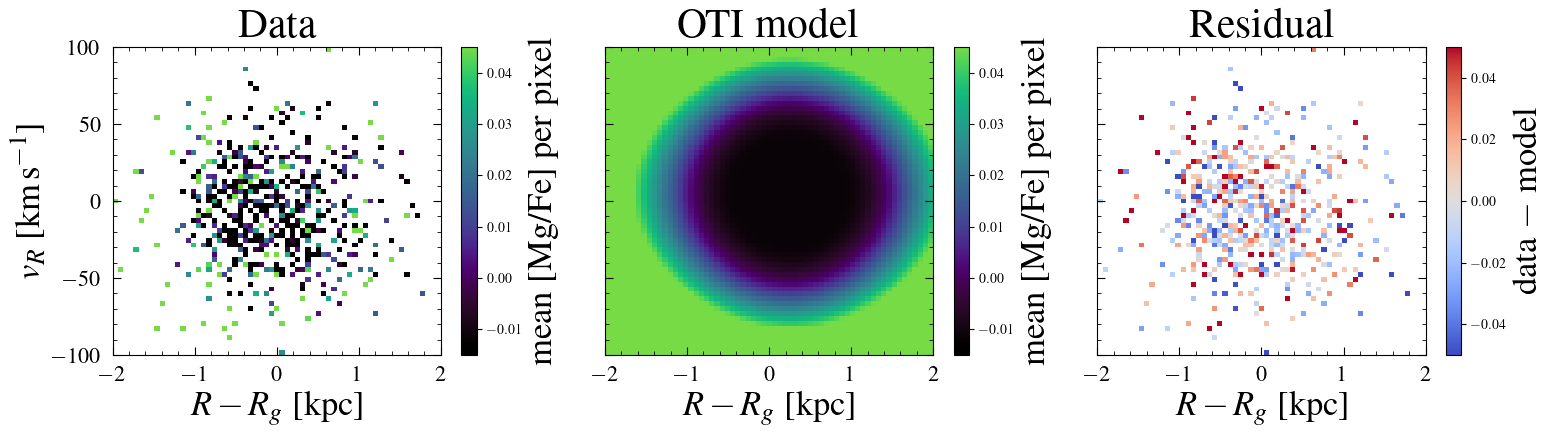

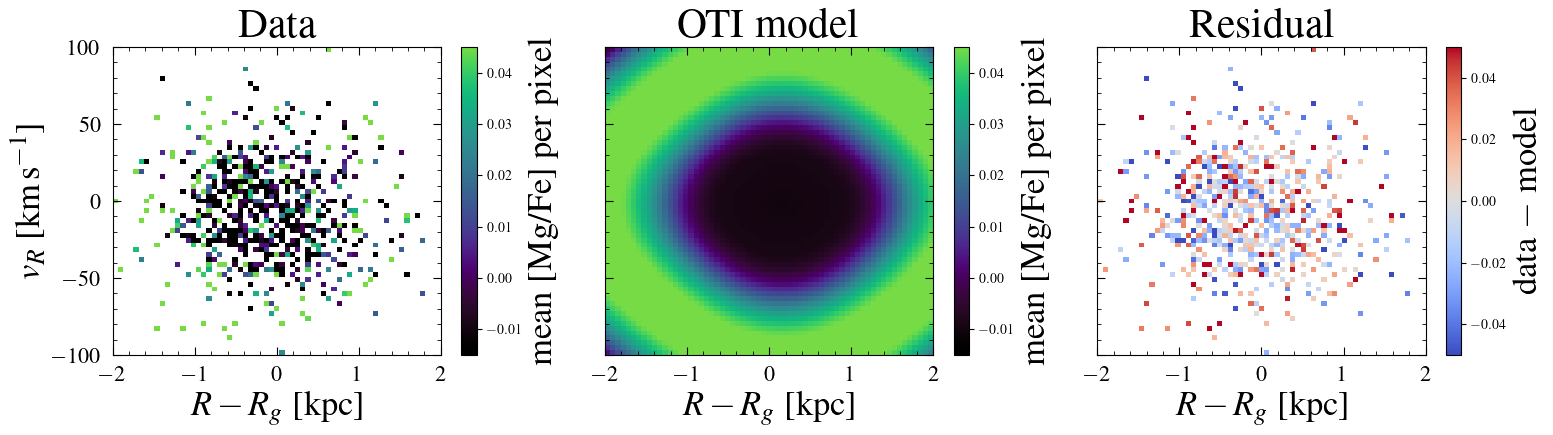

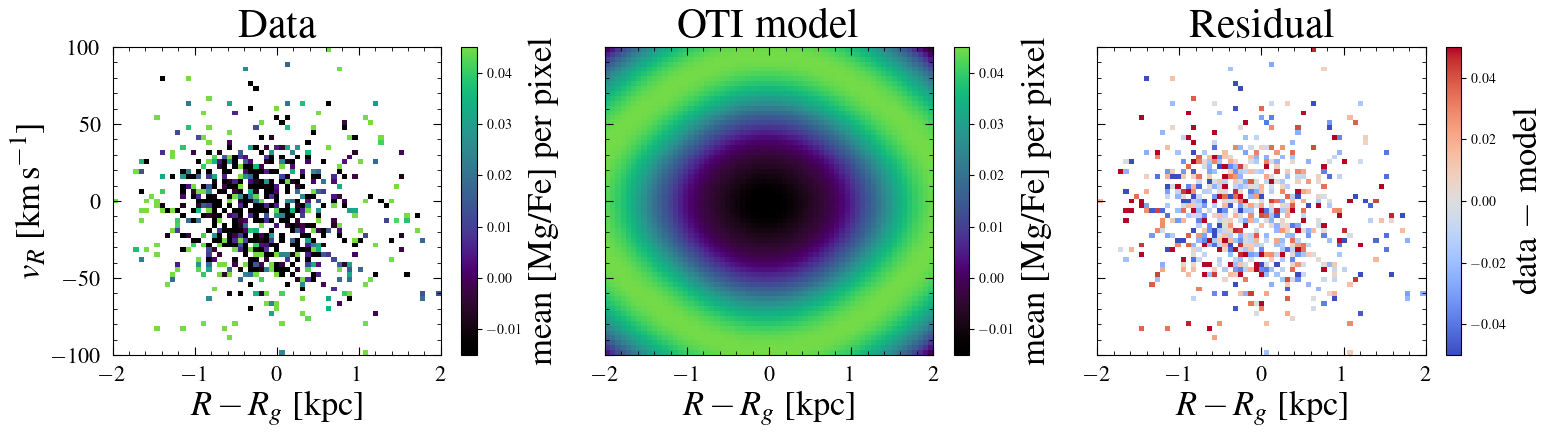

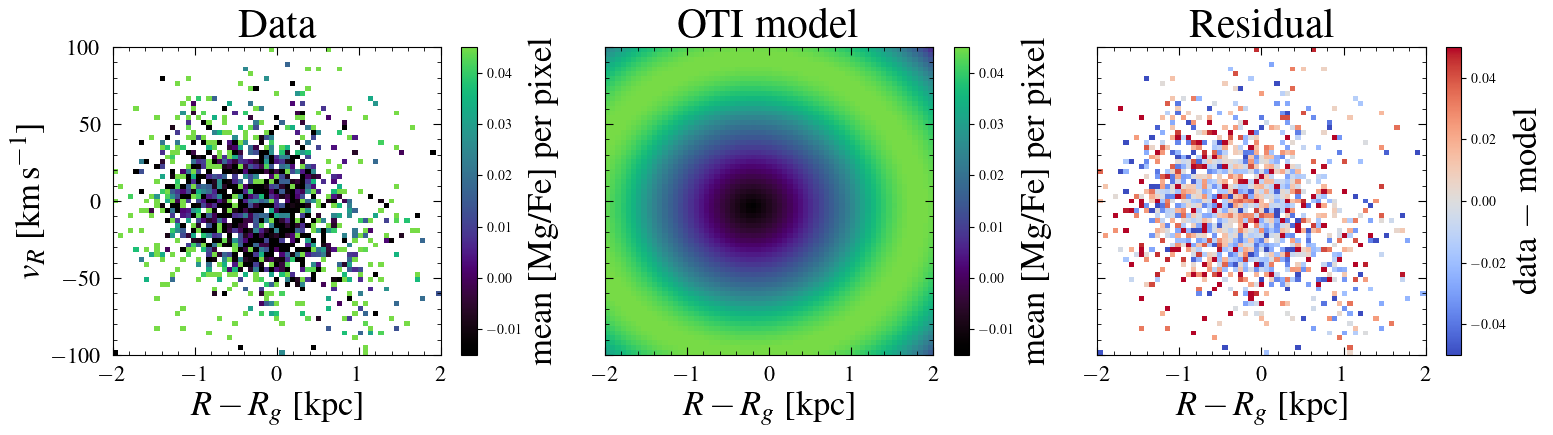

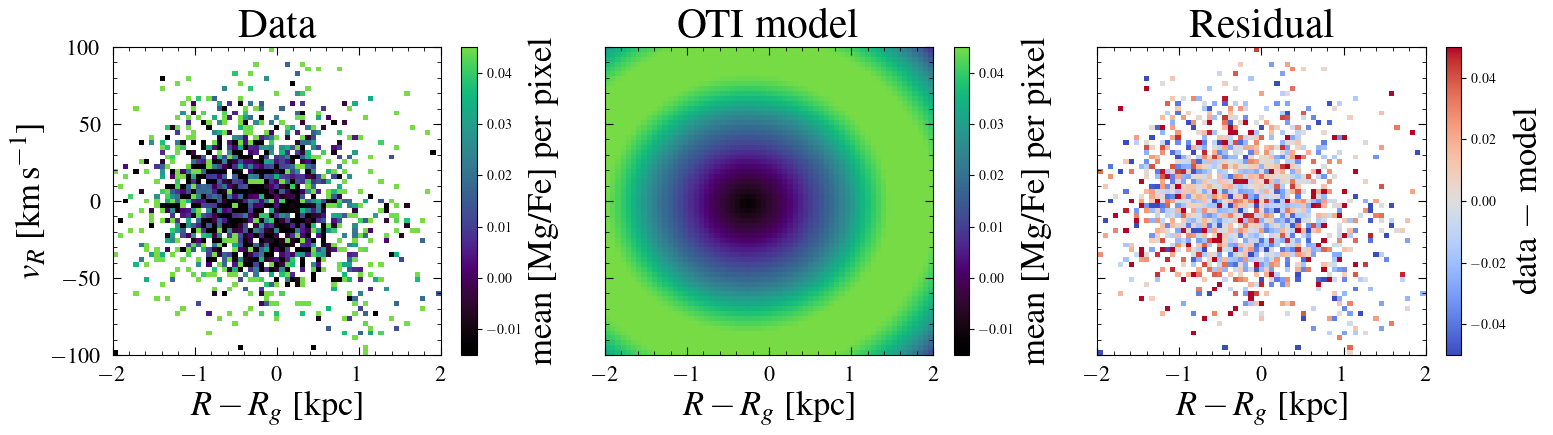

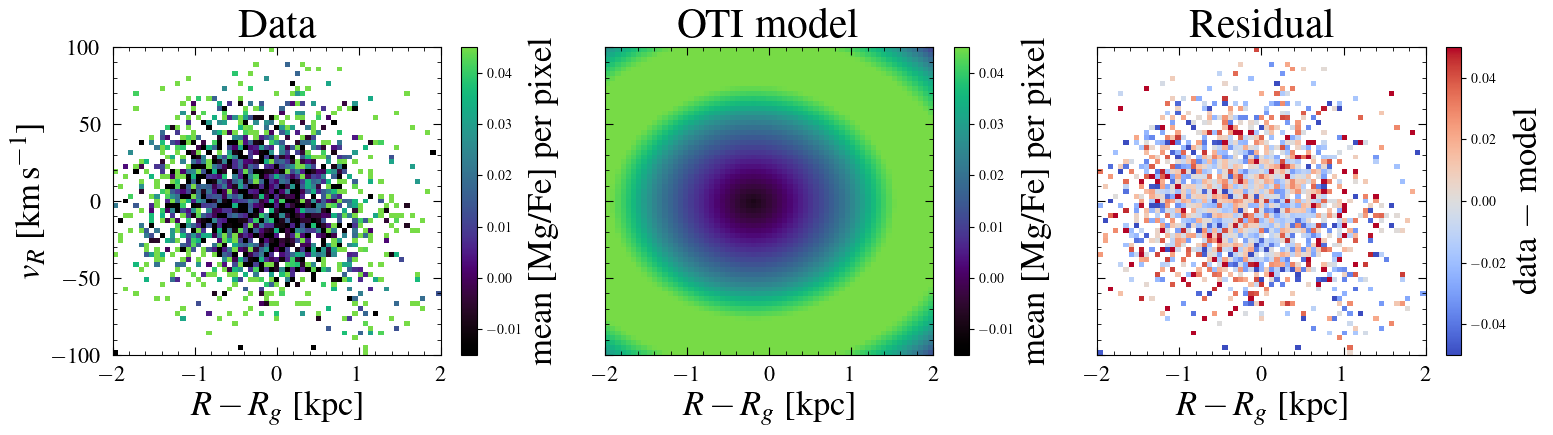

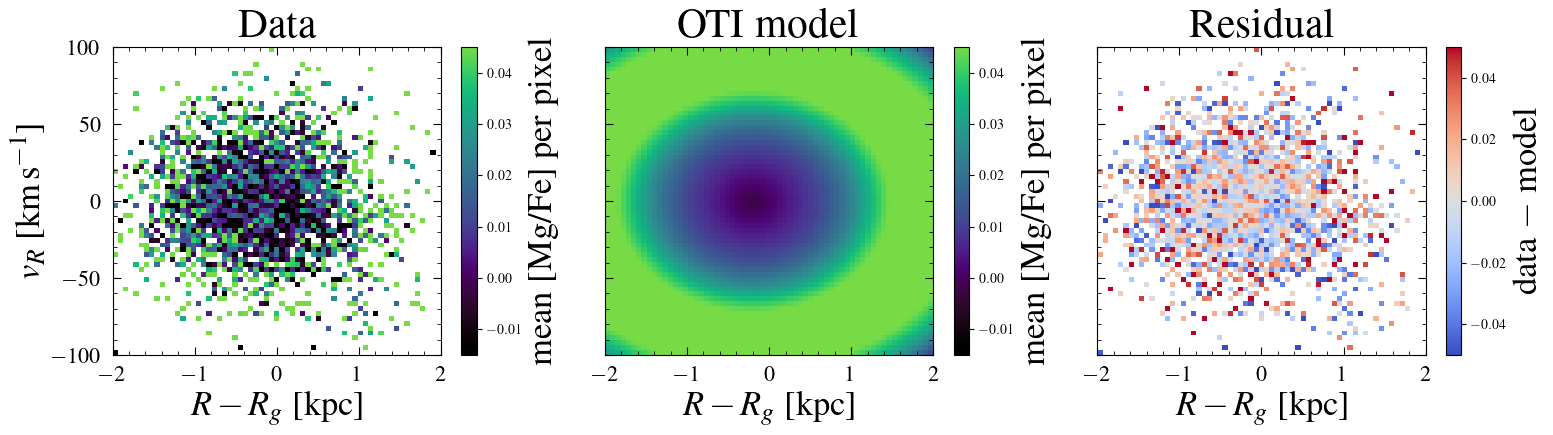

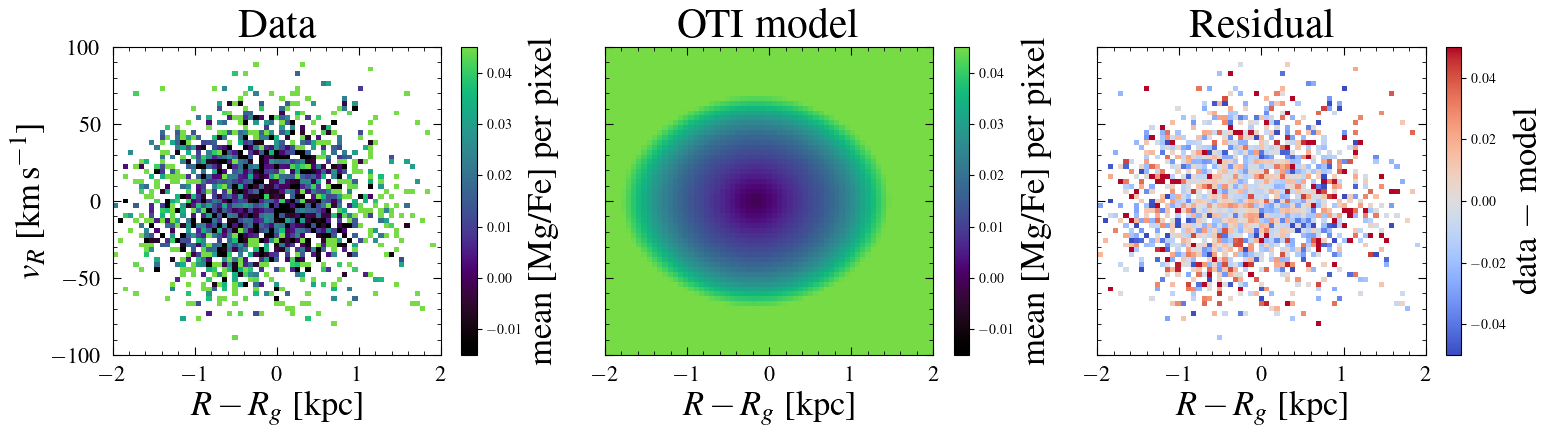

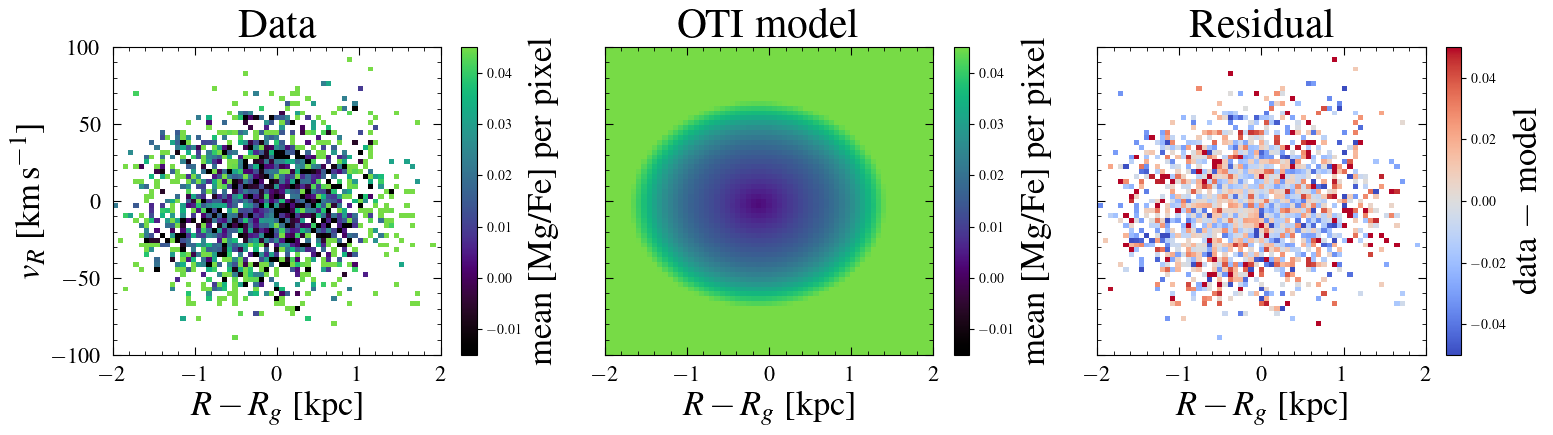

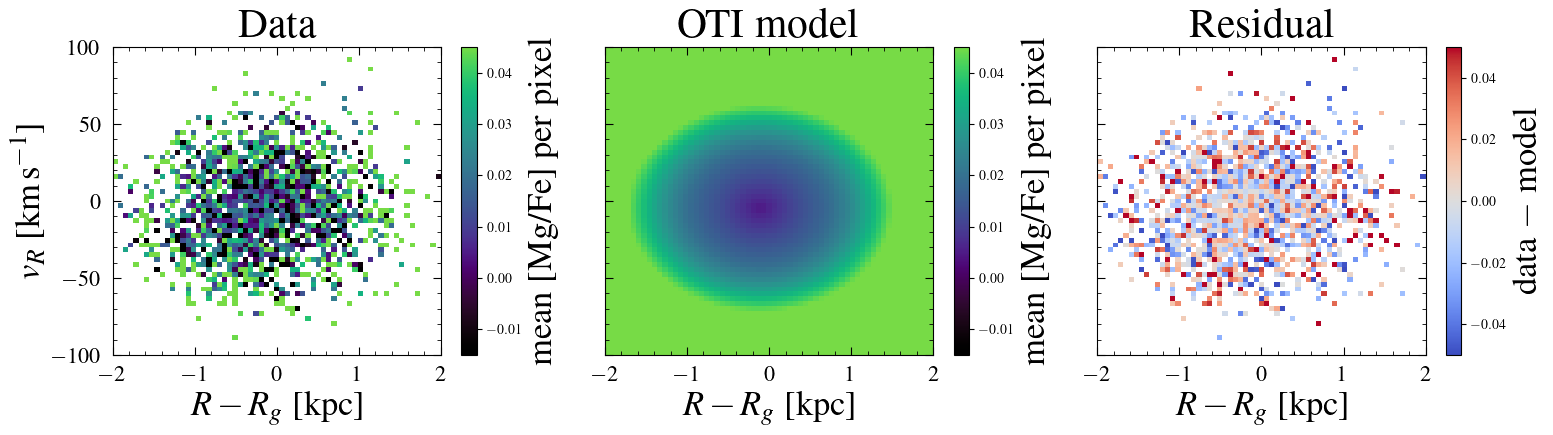

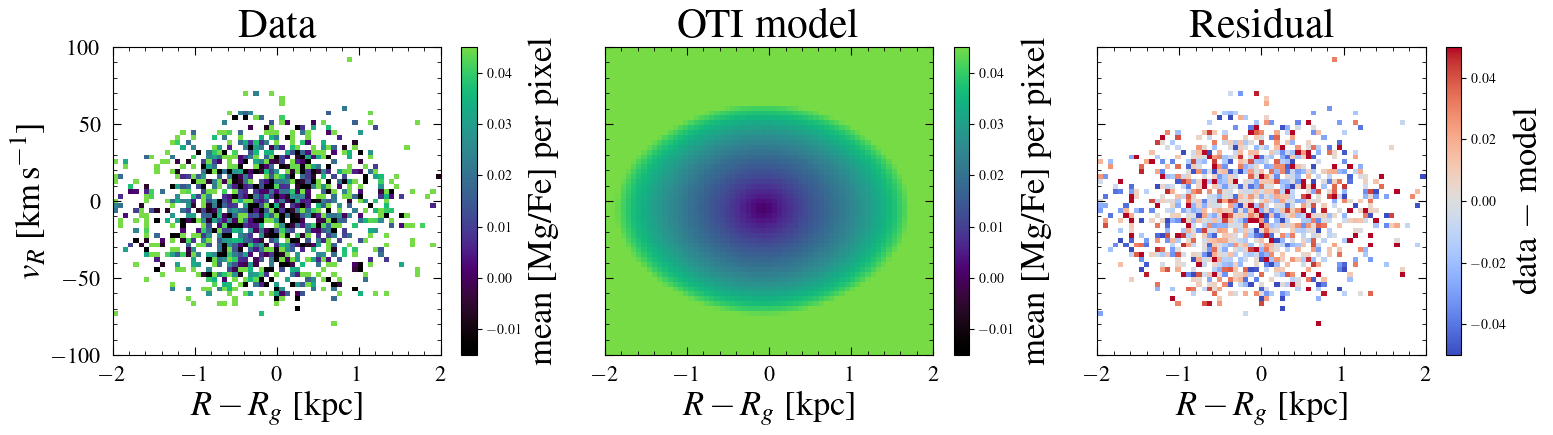

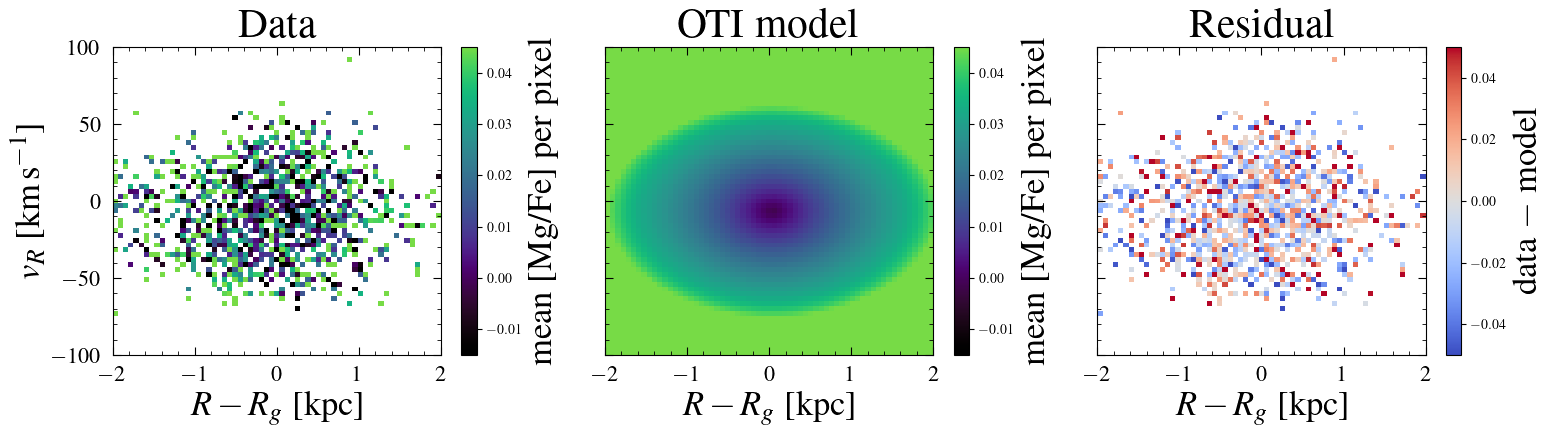

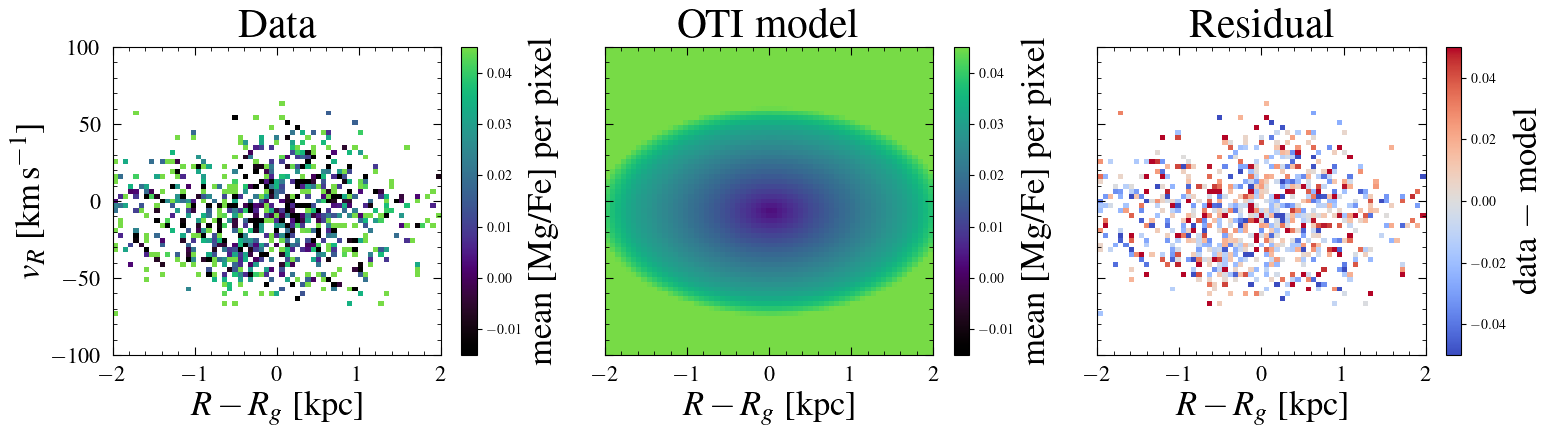

In [41]:
binsss = np.linspace(5,12,15)
bdata_clean_bins = []
res_bins_phi2 = []

for indx, i in enumerate(binsss[:-2]):
    mask_bin = (Rgal>i)&(Rgal<i+2)&wmask&(phi<0)&(phi_deg>-10)
    print(len(Rgal[mask_bin]))
    bdata_clean_bins_, res_bins_ = get_bins_plot(x_param, y_param, label, label_err, mask_bin)
    bdata_clean_bins.append(bdata_clean_bins_)
    res_bins_phi2.append(res_bins_)

In [42]:
rminusrg_bins = np.linspace(-1.9,1.9,19)
acc_R_phi2 = np.zeros((len(res_bins_phi2), len(rminusrg_bins)))

for indx, i in enumerate(res_bins_phi2):
    for jndx, j in enumerate(rminusrg_bins):
        freq = np.exp(i.params['ln_Omega0'])
        acc_ = -j * freq**2
        acc_R_phi2[indx, jndx] = acc_

acc_R_phi2 = acc_R_phi2*u.kpc/u.Myr**2
acc_R_phi2 = acc_R_phi2.to(u.km/(u.s * u.Myr))

In [43]:
dens_phi2 = np.zeros((len(res_bins_phi2), 10))
vc = 229.0 
dens_pos = np.zeros((len(res_bins_phi2)))

for indx, i in enumerate(res_bins_phi2):
    freq = np.exp(i.params['ln_Omega0'])
    for jndx, j in enumerate(rminusrg_bins[:10]):
        dens = (np.abs(j)*freq**2)/(4.*np.pi*G.value*Rs[indx])
        dens_phi2[indx, jndx] = dens

312
355
346
910
1259
1735
2298
2254
2350
2188
1864
1479
1051


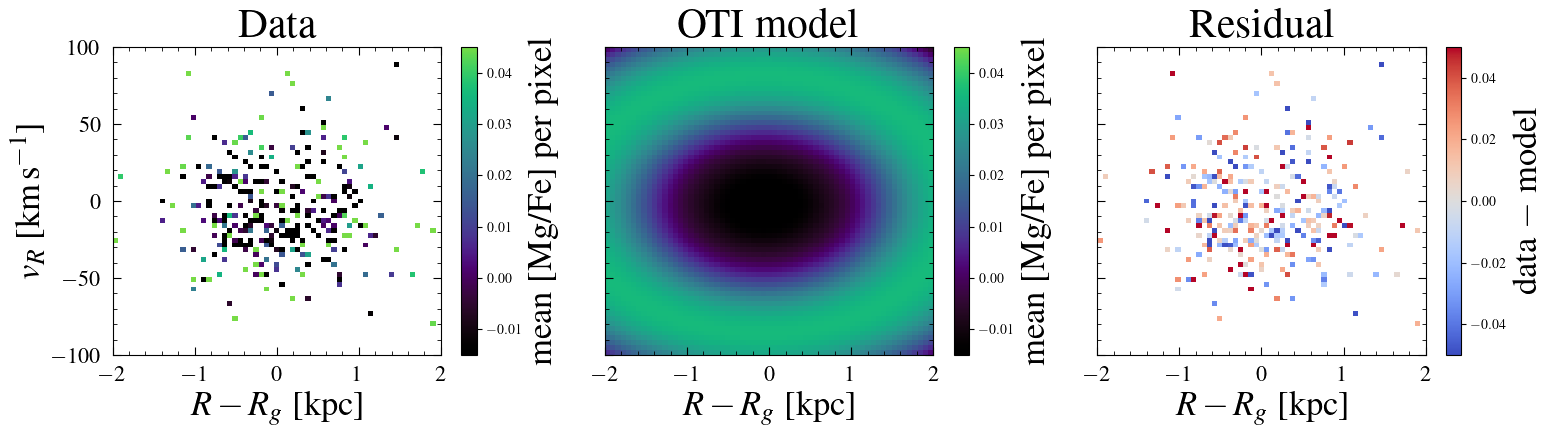

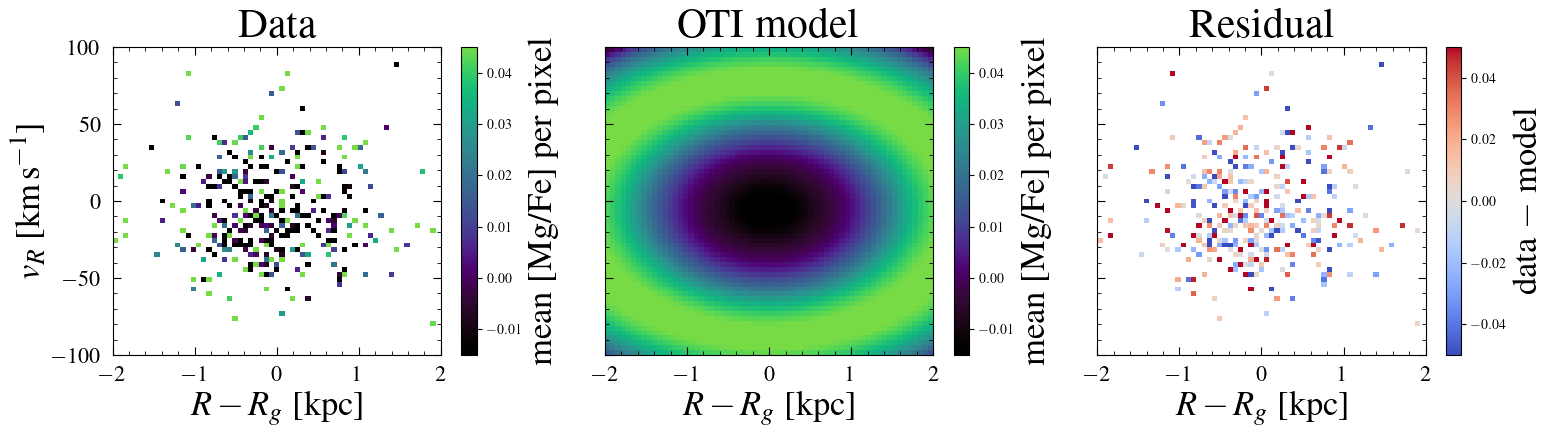

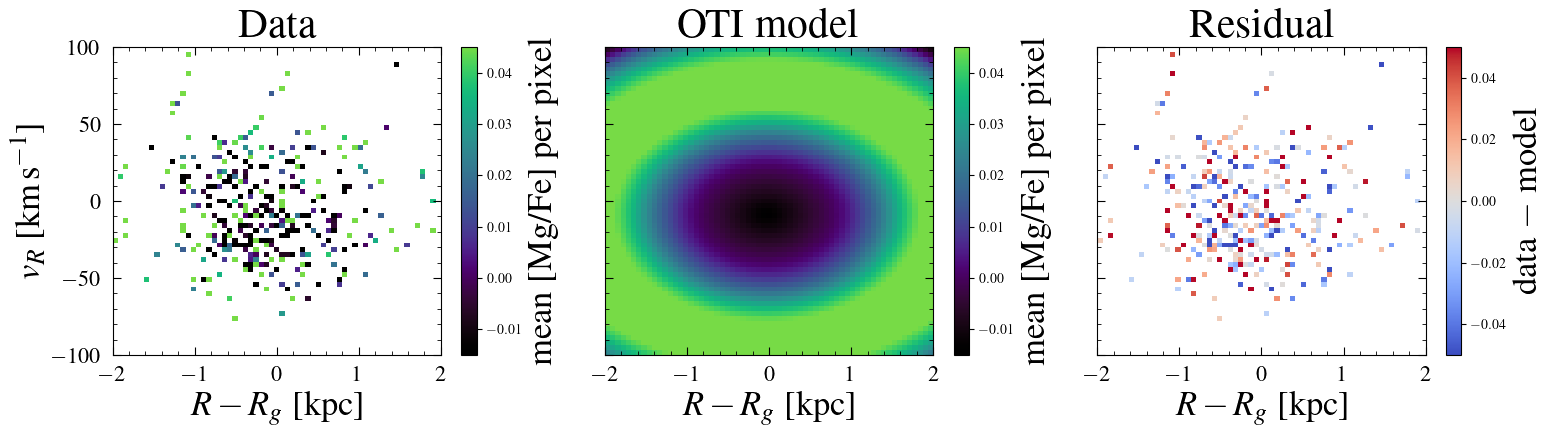

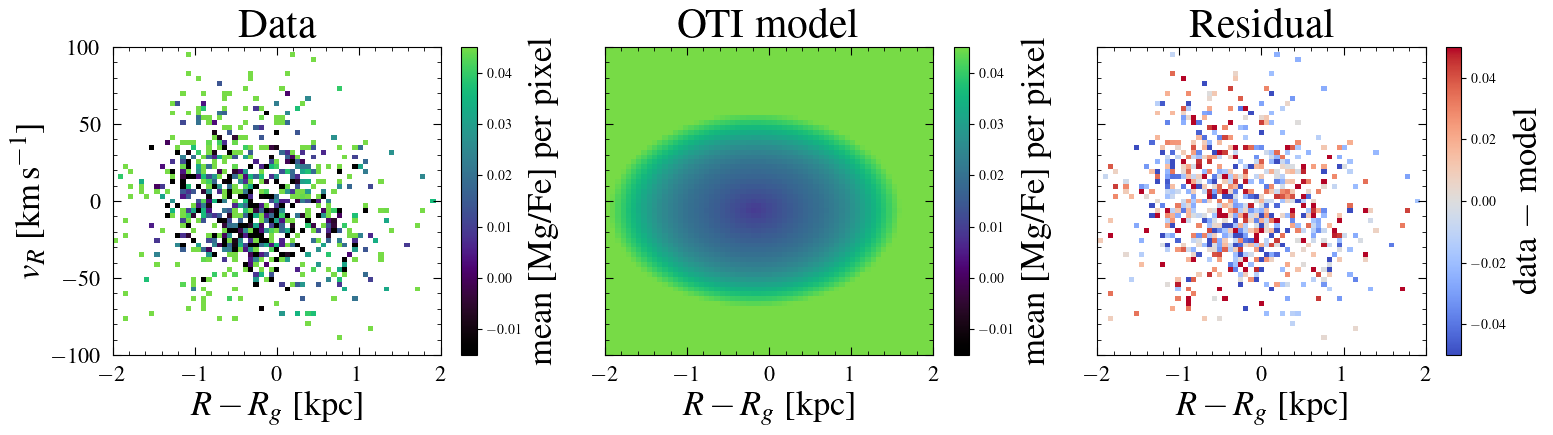

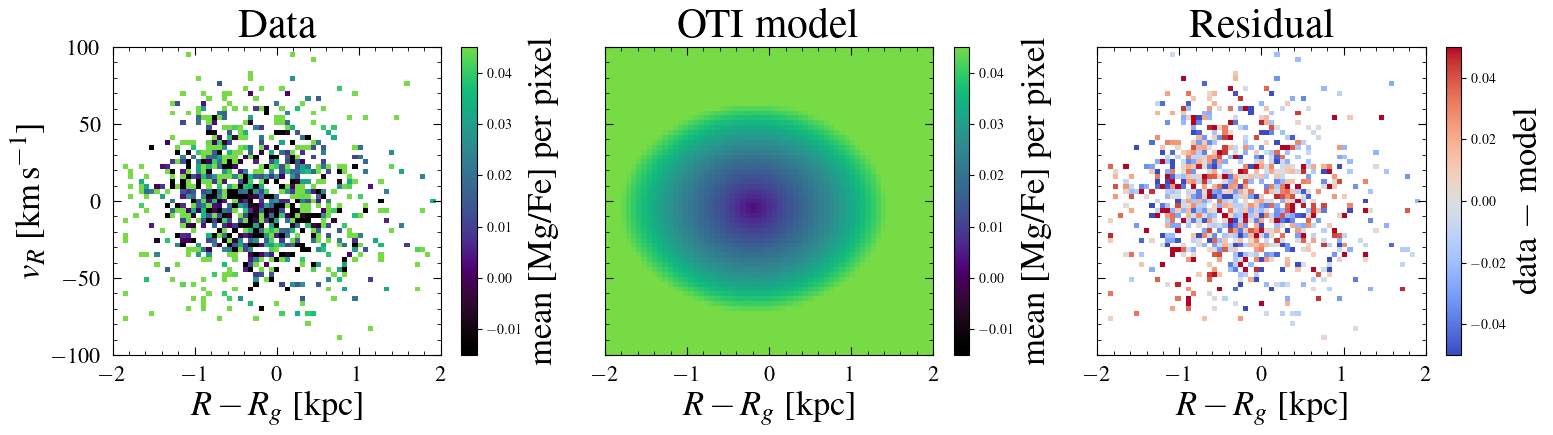

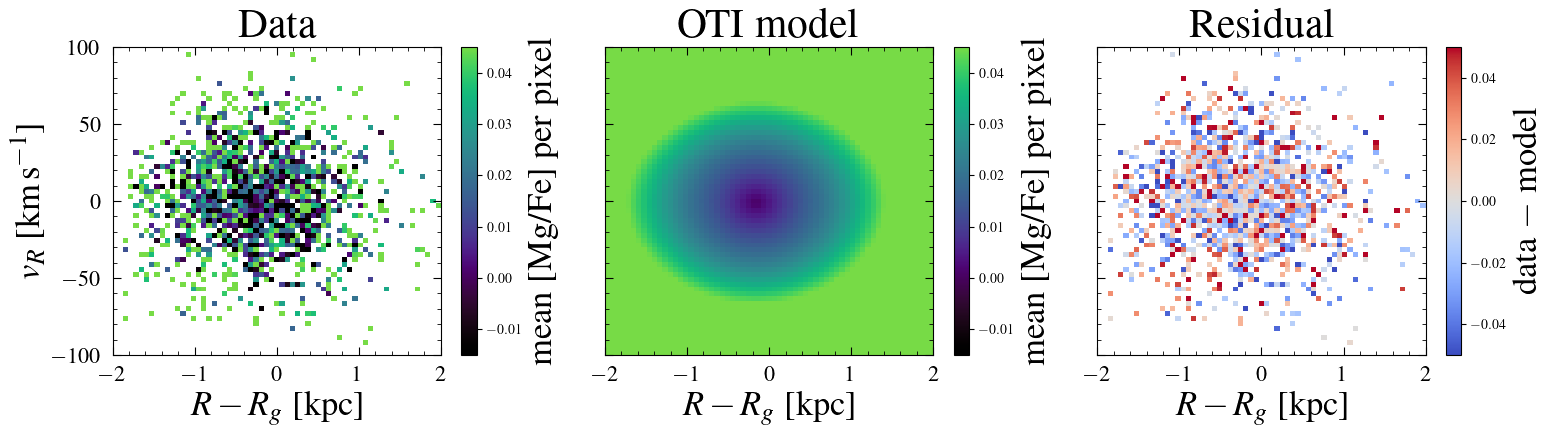

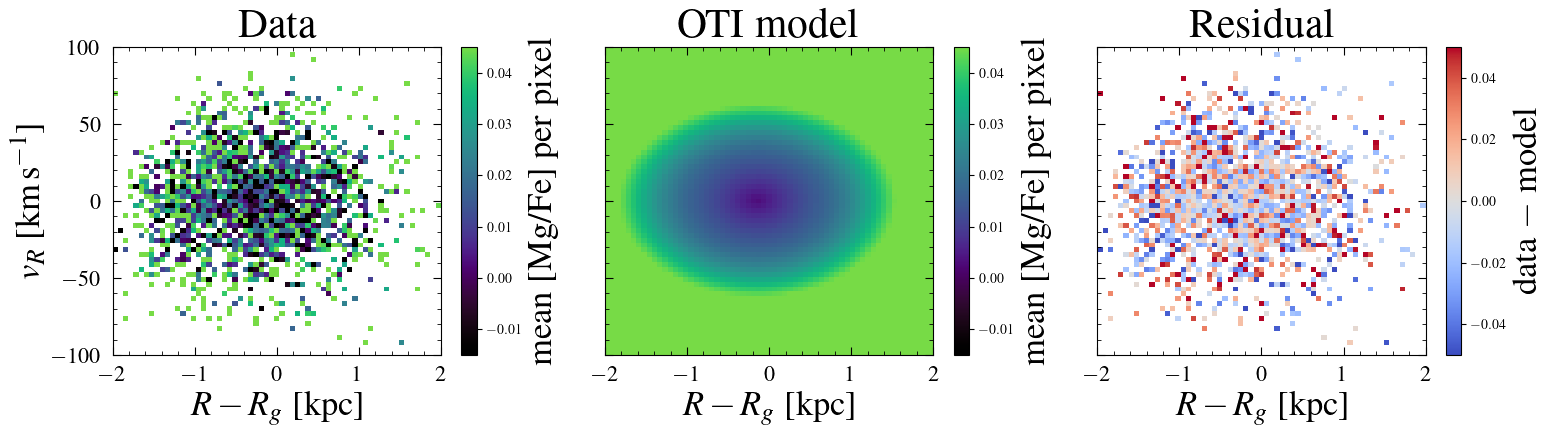

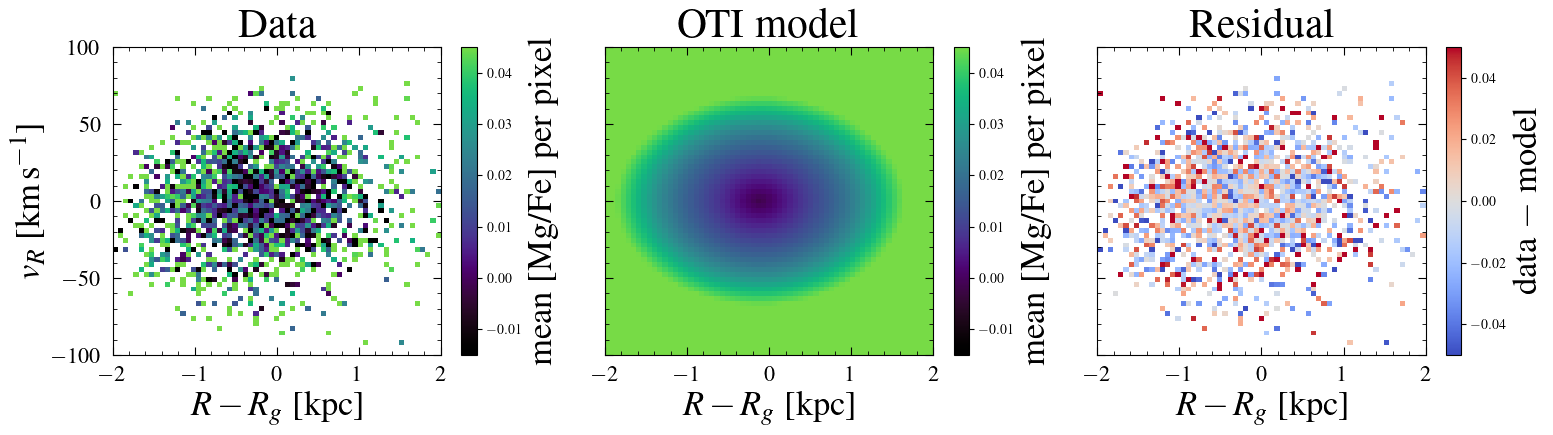

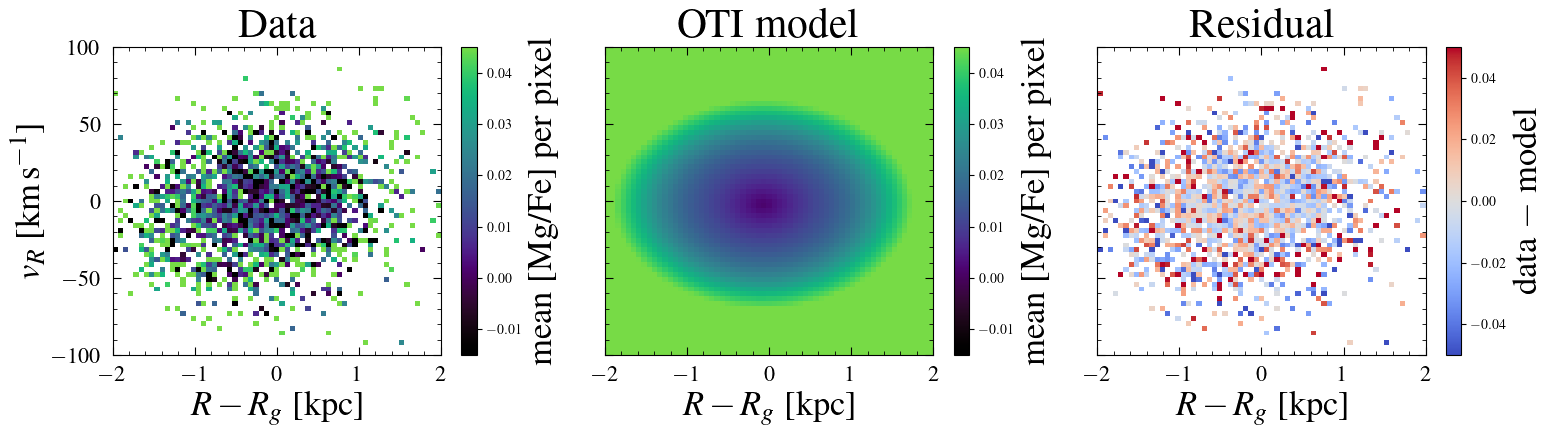

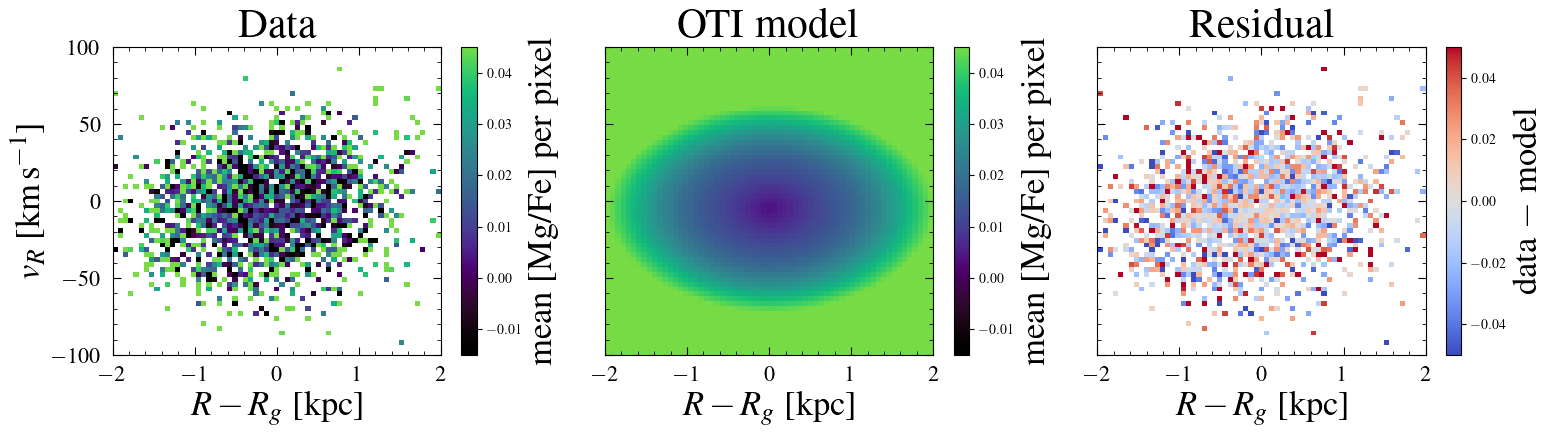

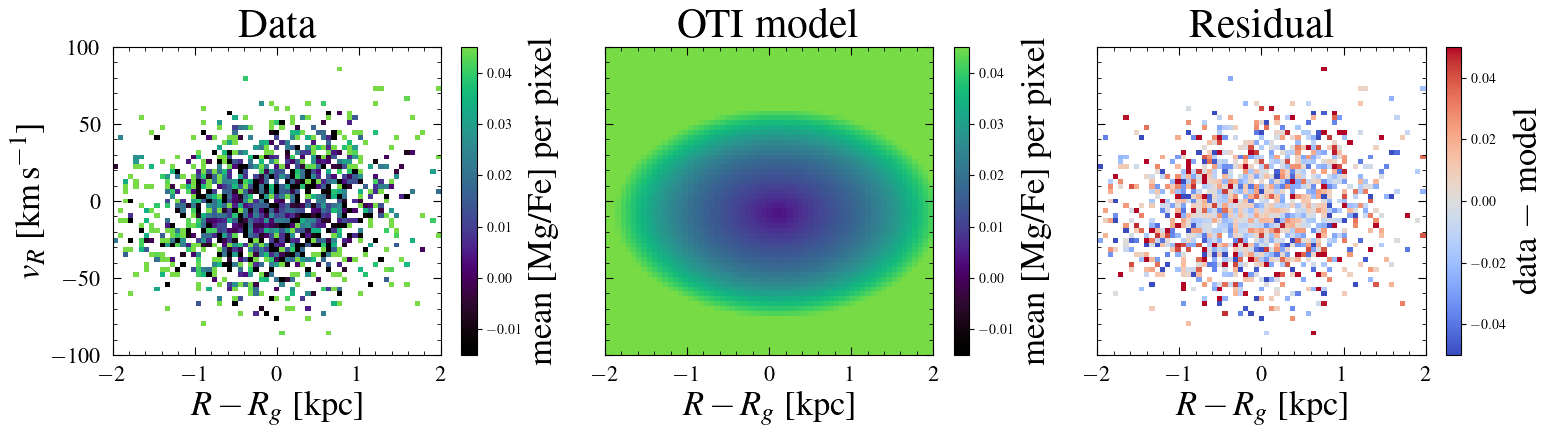

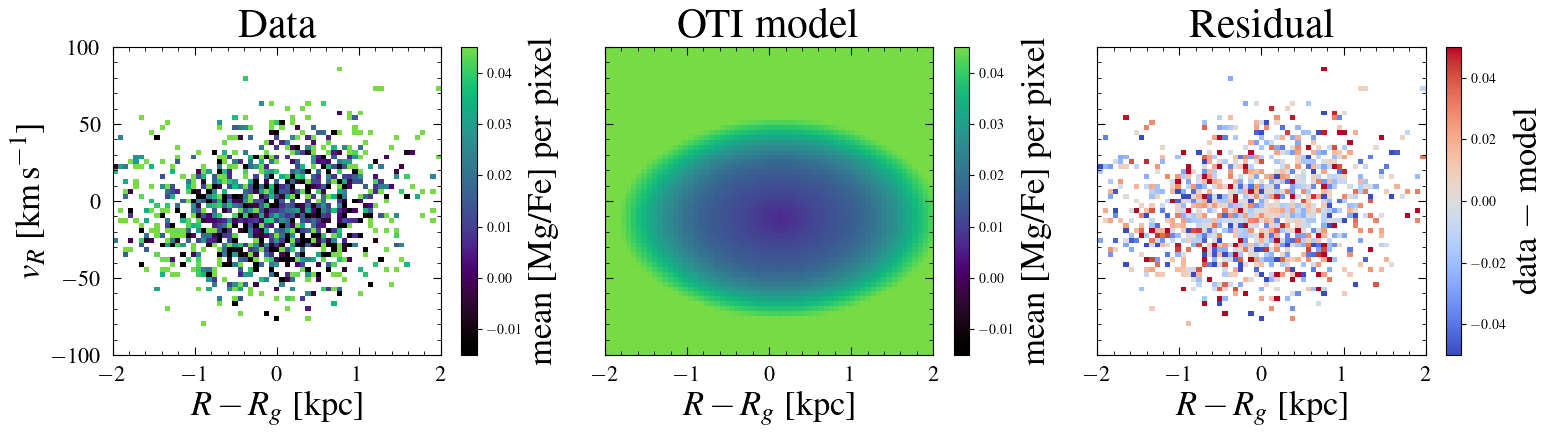

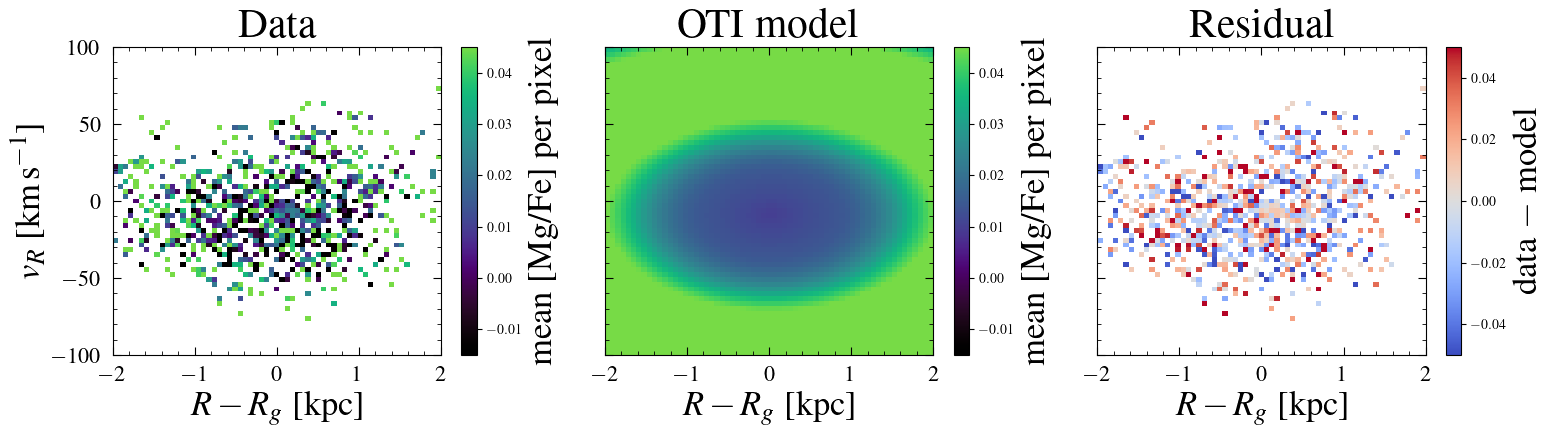

In [45]:
binsss = np.linspace(5,12,15)
bdata_clean_bins = []
res_bins_phi3 = []

for indx, i in enumerate(binsss[:-2]):
    mask_bin = (Rgal>i)&(Rgal<i+2)&wmask&(phi_deg>0)&(phi_deg<10)
    print(len(Rgal[mask_bin]))
    bdata_clean_bins_, res_bins_ = get_bins_plot(x_param, y_param, label, label_err, mask_bin)
    bdata_clean_bins.append(bdata_clean_bins_)
    res_bins_phi3.append(res_bins_)

In [46]:
rminusrg_bins = np.linspace(-1.9,1.9,19)
acc_R_phi3 = np.zeros((len(res_bins_phi3), len(rminusrg_bins)))

for indx, i in enumerate(res_bins_phi3):
    for jndx, j in enumerate(rminusrg_bins):
        freq = np.exp(i.params['ln_Omega0'])
        acc_ = -j * freq**2
        acc_R_phi3[indx, jndx] = acc_

acc_R_phi3 = acc_R_phi3*u.kpc/u.Myr**2
acc_R_phi3 = acc_R_phi3.to(u.km/(u.s * u.Myr))

In [47]:
dens_phi3 = np.zeros((len(res_bins_phi3), 10))
vc = 229.0 
dens_pos = np.zeros((len(res_bins_phi3)))

for indx, i in enumerate(res_bins_phi3):
    freq = np.exp(i.params['ln_Omega0'])
    for jndx, j in enumerate(rminusrg_bins[:10]):
        dens = (np.abs(j)*freq**2)/(4.*np.pi*G.value*Rs[indx])
        dens_phi3[indx, jndx] = dens

In [48]:
dens_phi1 = dens_phi1 * ((u.kg * u.s**2)/(u.Myr**2 * u.m**3))
dens_phi1 = dens_phi1.to(u.solMass/u.pc**3)
dens_phi2 = dens_phi2 * ((u.kg * u.s**2)/(u.Myr**2 * u.m**3))
dens_phi2 = dens_phi2.to(u.solMass/u.pc**3)
dens_phi3 = dens_phi3 * ((u.kg * u.s**2)/(u.Myr**2 * u.m**3))
dens_phi3 = dens_phi3.to(u.solMass/u.pc**3)
dens_phi1.shape, dens_phi2.shape, dens_phi3.shape

((13, 10), (13, 10), (13, 10))

In [49]:
dens_R_phi = np.concatenate((dens_phi1, dens_phi2))
dens_R_phi = np.concatenate((dens_R_phi, dens_phi3))
dens_R_phi

<Quantity [[0.01366117, 0.01214326, 0.01062535, 0.00910744, 0.00758954,
            0.00607163, 0.00455372, 0.00303581, 0.00151791, 0.        ],
           [0.0123708 , 0.01099626, 0.00962173, 0.0082472 , 0.00687266,
            0.00549813, 0.0041236 , 0.00274907, 0.00137453, 0.        ],
           [0.01055494, 0.00938217, 0.0082094 , 0.00703663, 0.00586386,
            0.00469109, 0.00351831, 0.00234554, 0.00117277, 0.        ],
           [0.00822161, 0.0073081 , 0.00639458, 0.00548107, 0.00456756,
            0.00365405, 0.00274054, 0.00182702, 0.00091351, 0.        ],
           [0.00653707, 0.00581073, 0.00508439, 0.00435805, 0.0036317 ,
            0.00290536, 0.00217902, 0.00145268, 0.00072634, 0.        ],
           [0.00628591, 0.00558747, 0.00488904, 0.00419061, 0.00349217,
            0.00279374, 0.0020953 , 0.00139687, 0.00069843, 0.        ],
           [0.00587298, 0.00522043, 0.00456787, 0.00391532, 0.00326277,
            0.00261021, 0.00195766, 0.00130511, 0.00065255

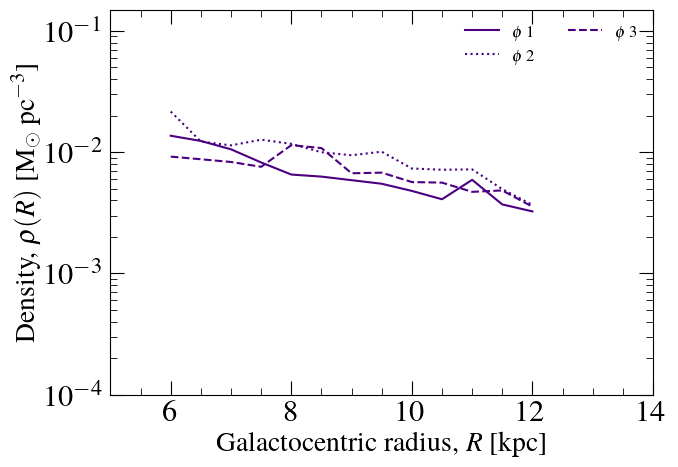

In [63]:
plt.figure(figsize=(7,5))
# plt.plot(Rs+1, dens_pos, lw=2, ls='dotted', color='k')
# for indx, i in enumerate(dens_phi1.T):
#     plt.plot(Rs[:-2]+1, i, label='$|R-R_g|$:'+str(np.abs(round(rminusrg_bins[indx],2))), color=colores[indx])
#     plt.plot(Rs[:-2]+1, dens_phi2.T[indx], color=colores[indx], ls='dotted')
#     plt.plot(Rs[:-2]+1, dens_phi3.T[indx], color=colores[indx], ls='dashed')
o = 0
plt.plot(Rs[:-2]+1, dens_phi1.T[o], color=colores[o], label='$\phi$ 1')
plt.plot(Rs[:-2]+1, dens_phi2.T[o], color=colores[o], ls='dotted', label='$\phi$ 2')
plt.plot(Rs[:-2]+1, dens_phi3.T[o], color=colores[o], ls='dashed', label='$\phi$ 3')
plt.xlim(5,14)
plt.ylim(1e-4,0.15)
plt.yscale('log')
# plt.errorbar(8.275, 0.081, yerr = 0.0015, color='r', capsize=5)
plt.xlabel('Galactocentric radius, $R$ [kpc]', fontsize=20)
plt.ylabel(r'Density, $\rho(R)$ [M$_{\odot}$ pc$^{-3}$]', fontsize=20)
plt.legend(loc='upper right', frameon=False, ncols=2, fontsize=12)
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=5, direction='in',top=True,right=True)
plt.minorticks_on()

# plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/dens-z0point2.pdf',dpi=250, bbox_inches = 'tight')


In [55]:
dens_phi1.T.shape

(10, 13)

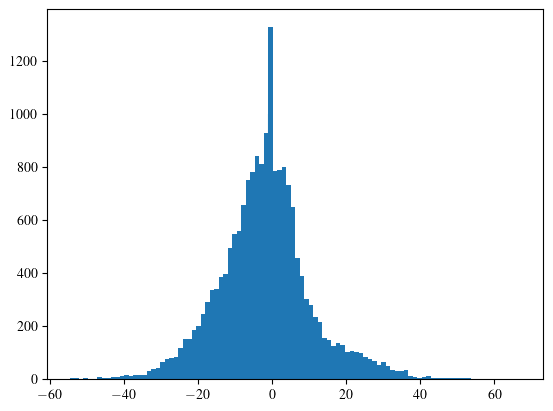

In [632]:
plt.hist(p[wmask],100);
plt.vlines(-np.pi/4,0,1e3)

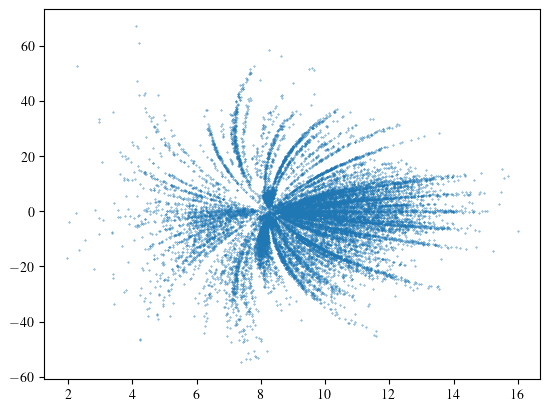

In [634]:
plt.scatter(Rgal[wmask],p[wmask],s=0.1)

Text(0, 0.5, '$v_R$ [$\\mathrm{km\\,s^{-1}}$]')

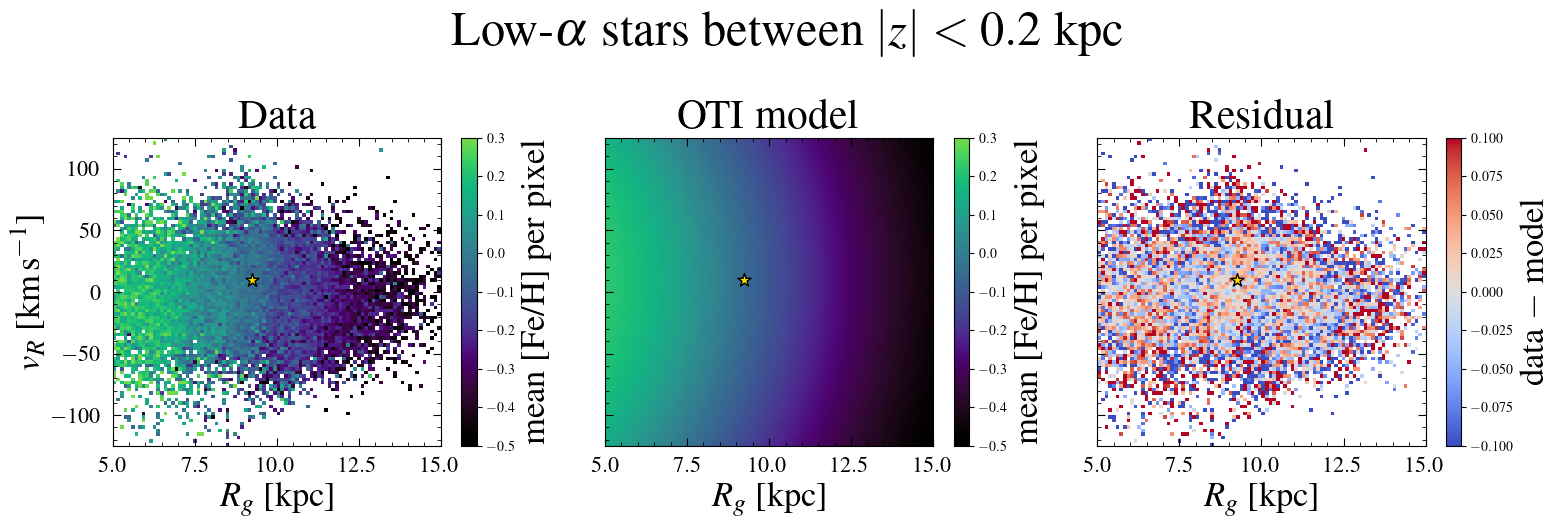

In [16]:
# visualise the data

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
fig.suptitle(r'Low-$\alpha$ stars between $|z|<0.2$ kpc', fontsize=35, y=1.2)

ax = axes[0]
ax.set_title('Data', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"],
    vmin=-0.5,
    vmax=0.3,
    cmap=cm.lavender,
)
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
ax.scatter(9.25, 10, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
ax.set_ylim(-125,125)
ax.set_xlim(5,15)

ax = axes[1]
ax.set_title('OTI model', fontsize=30)
model_H = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    model_H,
    vmin=-0.5,
    vmax=0.3,
    cmap=cm.lavender
)
ax.scatter(9.25, 10, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
ax.set_ylim(-125,125)
ax.set_xlim(5,15)

ax = axes[2]
ax.set_title('Residual', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"] - model_H,
    vmin=-0.1,
    vmax=0.1,
    cmap='coolwarm'
)

cb = fig.colorbar(cs, ax=ax)
cb.set_label("data $-$ model", fontsize=25)
ax.set_ylim(-125,125)
ax.set_xlim(5,15)
ax.scatter(9.25, 10, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()

for ax in axes:
    ax.set_xlabel(f"$R_g$ [{u.kpc:latex_inline}]", fontsize=25)
axes[0].set_ylabel(f"$v_R$ [{u.km/u.s:latex_inline}]", fontsize=25)

Now with $R-R_g$

In [31]:
# create the bins to model the data in R-vR
nbins = 91
bins = {
    "pos": np.linspace(-1, 1, nbins)*u.kpc,
    "vel": np.linspace(-125, 125, nbins)*u.km/u.s,
}

In [32]:
x_param = (Rgal-Rg) * u.kpc
y_param = vR * u.km/u.s
label = data['FE_H']
label_err = data['FE_H_ERR']

bdata = oti.data.get_binned_label(
    pos=x_param[wmask4].astype(np.float32),
    vel=y_param[wmask4].astype(np.float32),
    label=label[wmask4].astype(np.float32),
    label_err=label_err[wmask4].astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=2,
)

bdata_clean = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=bdata["label_err"],
)
bdata_mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

In [33]:
res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
res.state.success, res.state.iter_num

(True, 136)

Text(0, 0.5, '$v_R$ [$\\mathrm{km\\,s^{-1}}$]')

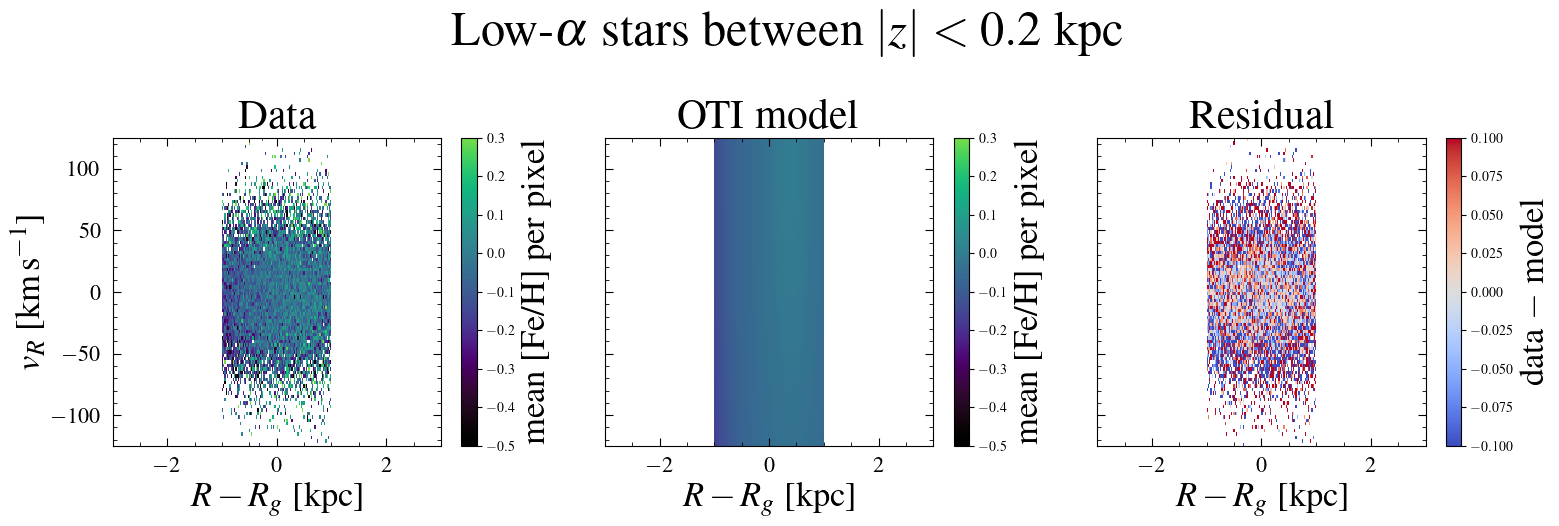

In [34]:
# visualise the data

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
fig.suptitle(r'Low-$\alpha$ stars between $|z|<0.2$ kpc', fontsize=35, y=1.2)

ax = axes[0]
ax.set_title('Data', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"],
    vmin=-0.5,
    vmax=0.3,
    cmap=cm.lavender,
)
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
# ax.scatter(9.25, 10, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
ax.set_ylim(-125,125)
ax.set_xlim(-3,3)

ax = axes[1]
ax.set_title('OTI model', fontsize=30)
model_H = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    model_H,
    vmin=-0.5,
    vmax=0.3,
    cmap=cm.lavender
)
# ax.scatter(9.25, 10, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
ax.set_ylim(-125,125)
ax.set_xlim(-3,3)

ax = axes[2]
ax.set_title('Residual', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"] - model_H,
    vmin=-0.1,
    vmax=0.1,
    cmap='coolwarm'
)

cb = fig.colorbar(cs, ax=ax)
cb.set_label("data $-$ model", fontsize=25)
ax.set_ylim(-125,125)
ax.set_xlim(-3,3)
# ax.scatter(9.25, 10, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()

for ax in axes:
    ax.set_xlabel(f"$R - R_g$ [{u.kpc:latex_inline}]", fontsize=25)
axes[0].set_ylabel(f"$v_R$ [{u.km/u.s:latex_inline}]", fontsize=25)

# Now bin by age

In [22]:
# create the bins to model the data in R-vR
nbins = 91
bins = {
    "pos": np.linspace(5, 15, nbins)*u.kpc,
    "vel": np.linspace(-125, 125, nbins)*u.km/u.s,
}

In [23]:
x_param = Rgal * u.kpc
y_param = vR * u.km/u.s
label = data['FE_H']
label_err = data['FE_H_ERR']

bdata = oti.data.get_binned_label(
    pos=x_param[wmask].astype(np.float32),
    vel=y_param[wmask].astype(np.float32),
    label=label[wmask].astype(np.float32),
    label_err=label_err[wmask].astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=2,
)

bdata_clean = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=bdata["label_err"],
)
bdata_mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

In [24]:
res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
res.state.success, res.state.iter_num

(True, 79)

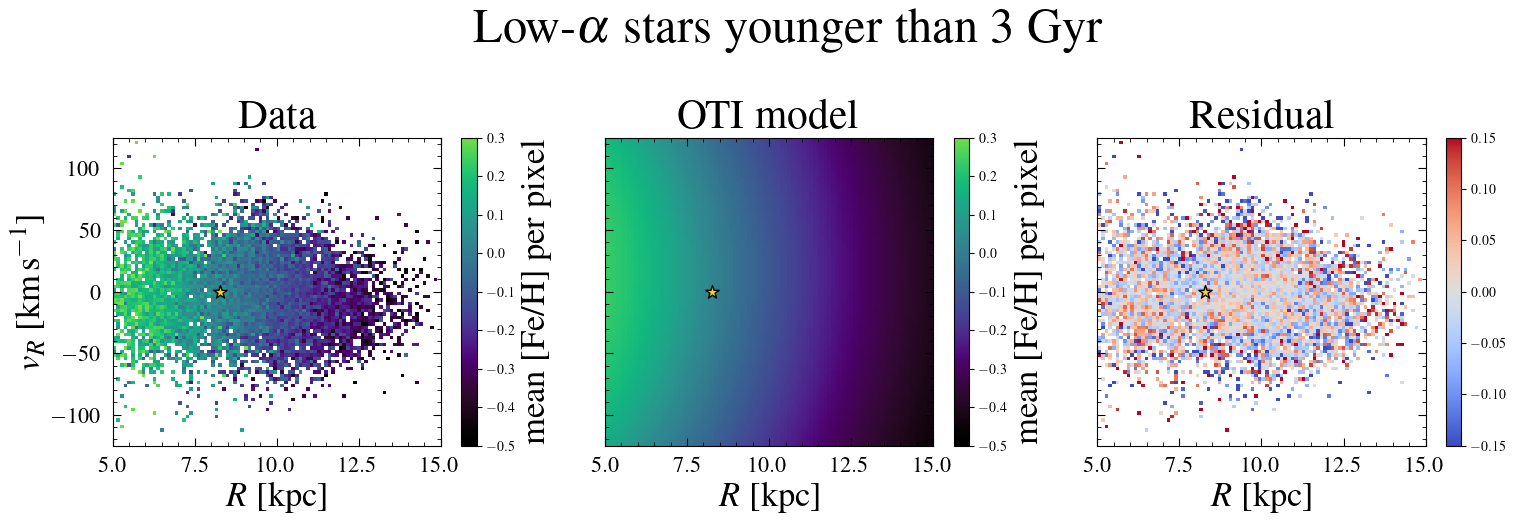

In [26]:
# visualise the data

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
fig.suptitle(r'Low-$\alpha$ stars younger than 3 Gyr', fontsize=35, y=1.2)

ax = axes[0]
ax.set_title('Data', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"],
    vmin=-0.5,
    vmax=0.3,
    cmap=cm.lavender,
)
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
# ax.set_ylim(-100,100)
ax.set_xlim(0,16)

ax = axes[1]
ax.set_title('OTI model', fontsize=30)
model_H = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    model_H,
    vmin=-0.5,
    vmax=0.3,
    cmap=cm.lavender
)
ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
# ax.set_ylim(-100,100)
ax.set_xlim(5,15)

ax = axes[2]
ax.set_title('Residual', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"] - model_H,
    vmin=-0.15,
    vmax=0.15,
    cmap='coolwarm'
)

cb = fig.colorbar(cs, ax=ax)
# cb.set_label("Residual")
# ax.set_ylim(-100,100)
ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
ax.set_xlim(5,15)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()

for ax in axes:
    ax.set_xlabel(f"$R$ [{u.kpc:latex_inline}]", fontsize=25)
axes[0].set_ylabel(f"$v_R$ [{u.km/u.s:latex_inline}]", fontsize=25)

plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/data-model-res-Rgal-young',dpi=250, bbox_inches = 'tight')


Repeat the exercise with $R_g$

For young stars

In [27]:
x_param = Rg * u.kpc
y_param = vR * u.km/u.s
label = data['FE_H']
label_err = data['FE_H_ERR']

bdata = oti.data.get_binned_label(
    pos=x_param[wmask].astype(np.float32),
    vel=y_param[wmask].astype(np.float32),
    label=label[wmask].astype(np.float32),
    label_err=label_err[wmask].astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=2,
)

bdata_clean = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=bdata["label_err"],
)
bdata_mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

In [28]:
res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
res.state.success, res.state.iter_num

(True, 535)

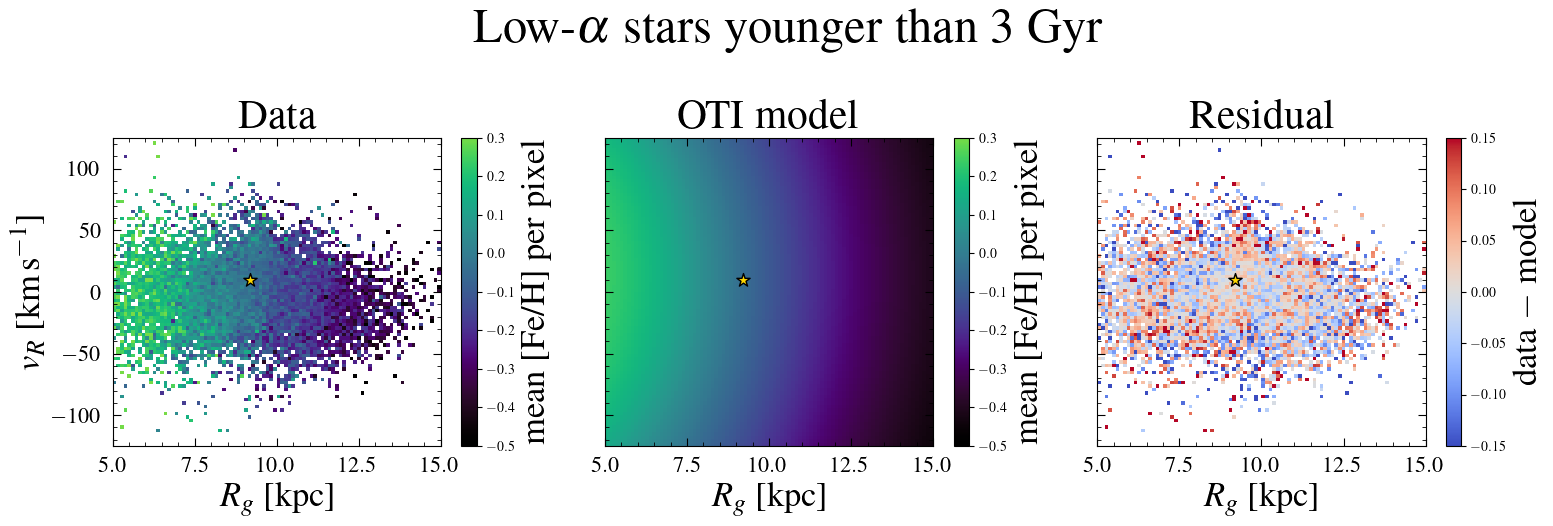

In [29]:
# visualise the data

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
fig.suptitle(r'Low-$\alpha$ stars younger than 3 Gyr', fontsize=35, y=1.2)

ax = axes[0]
ax.set_title('Data', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"],
    vmin=-0.5,
    vmax=0.3,
    cmap=cm.lavender,
)
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
ax.scatter(9.2, 10, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
# ax.set_ylim(-100,100)
ax.set_xlim(0,16)

ax = axes[1]
ax.set_title('OTI model', fontsize=30)
model_H = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    model_H,
    vmin=-0.5,
    vmax=0.3,
    cmap=cm.lavender
)
ax.scatter(9.2, 10, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
# ax.set_ylim(-100,100)
ax.set_xlim(5,15)

ax = axes[2]
ax.set_title('Residual', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"] - model_H,
    vmin=-0.15,
    vmax=0.15,
    cmap='coolwarm'
)

cb = fig.colorbar(cs, ax=ax)
cb.set_label("data $-$ model", fontsize=25)
# ax.set_ylim(-100,100)
ax.scatter(9.2, 10, marker='*', color='gold', s=100, edgecolors='k')
ax.set_xlim(5,15)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()

for ax in axes:
    ax.set_xlabel(f"$R_g$ [{u.kpc:latex_inline}]", fontsize=25)
axes[0].set_ylabel(f"$v_R$ [{u.km/u.s:latex_inline}]", fontsize=25)

plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/data-model-res-Rg-young',dpi=250, bbox_inches = 'tight')


For intermediate age stars

In [111]:
x_param = Rg * u.kpc
y_param = vR * u.km/u.s
label = data['FE_H']
label_err = data['FE_H_ERR']

mask_z = np.abs(data['xyz'][:,2])<0.2

bdata = oti.data.get_binned_label(
    pos=x_param[wmask2&mask_z].astype(np.float32),
    vel=y_param[wmask2&mask_z].astype(np.float32),
    label=label[wmask2&mask_z].astype(np.float32),
    label_err=label_err[wmask2&mask_z].astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=2,
)

bdata_clean = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=bdata["label_err"],
)
bdata_mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

In [112]:
res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
res.state.success, res.state.iter_num

(True, 885)

Text(0, 0.5, '$v_R$ [$\\mathrm{km\\,s^{-1}}$]')

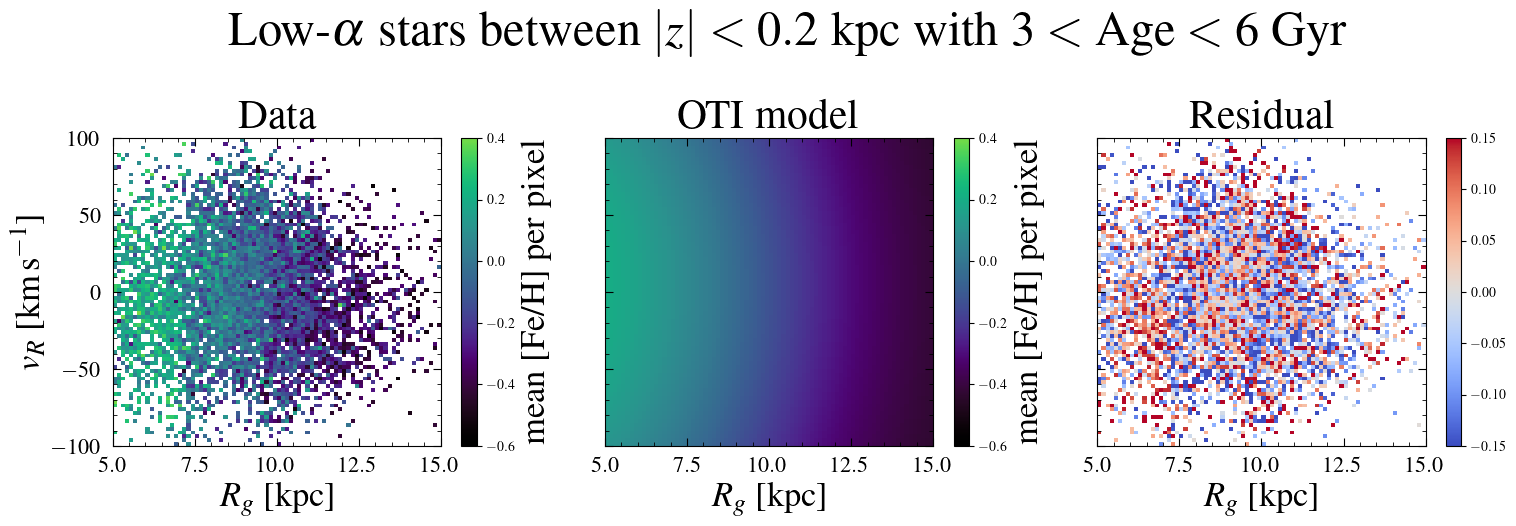

In [113]:
# visualise the data

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
fig.suptitle(r'Low-$\alpha$ stars between $|z|<0.2$ kpc with $3 < \mathrm{Age} < 6$ Gyr', fontsize=35, y=1.2)

ax = axes[0]
ax.set_title('Data', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"],
    vmin=-0.6,
    vmax=0.4,
    cmap=cm.lavender,
)
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
# ax.set_ylim(-100,100)
ax.set_xlim(0,16)

ax = axes[1]
ax.set_title('OTI model', fontsize=30)
model_H = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    model_H,
    vmin=-0.6,
    vmax=0.4,
    cmap=cm.lavender
)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
# ax.set_ylim(-100,100)
ax.set_xlim(5,15)

ax = axes[2]
ax.set_title('Residual', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"] - model_H,
    vmin=-0.15,
    vmax=0.15,
    cmap='coolwarm'
)

cb = fig.colorbar(cs, ax=ax)
# cb.set_label("Residual")
# ax.set_ylim(-100,100)
ax.set_xlim(5,15)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()

for ax in axes:
    ax.set_xlabel(f"$R_g$ [{u.kpc:latex_inline}]", fontsize=25)
axes[0].set_ylabel(f"$v_R$ [{u.km/u.s:latex_inline}]", fontsize=25)

For old stars

In [114]:
x_param = Rg * u.kpc
y_param = vR * u.km/u.s
label = data['FE_H']
label_err = data['FE_H_ERR']

mask_z = np.abs(data['xyz'][:,2])<0.2

bdata = oti.data.get_binned_label(
    pos=x_param[wmask3&mask_z].astype(np.float32),
    vel=y_param[wmask3&mask_z].astype(np.float32),
    label=label[wmask3&mask_z].astype(np.float32),
    label_err=label_err[wmask3&mask_z].astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=2,
)

bdata_clean = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=bdata["label_err"],
)
bdata_mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

In [115]:
res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
res.state.success, res.state.iter_num

(True, 33)

Text(0, 0.5, '$v_R$ [$\\mathrm{km\\,s^{-1}}$]')

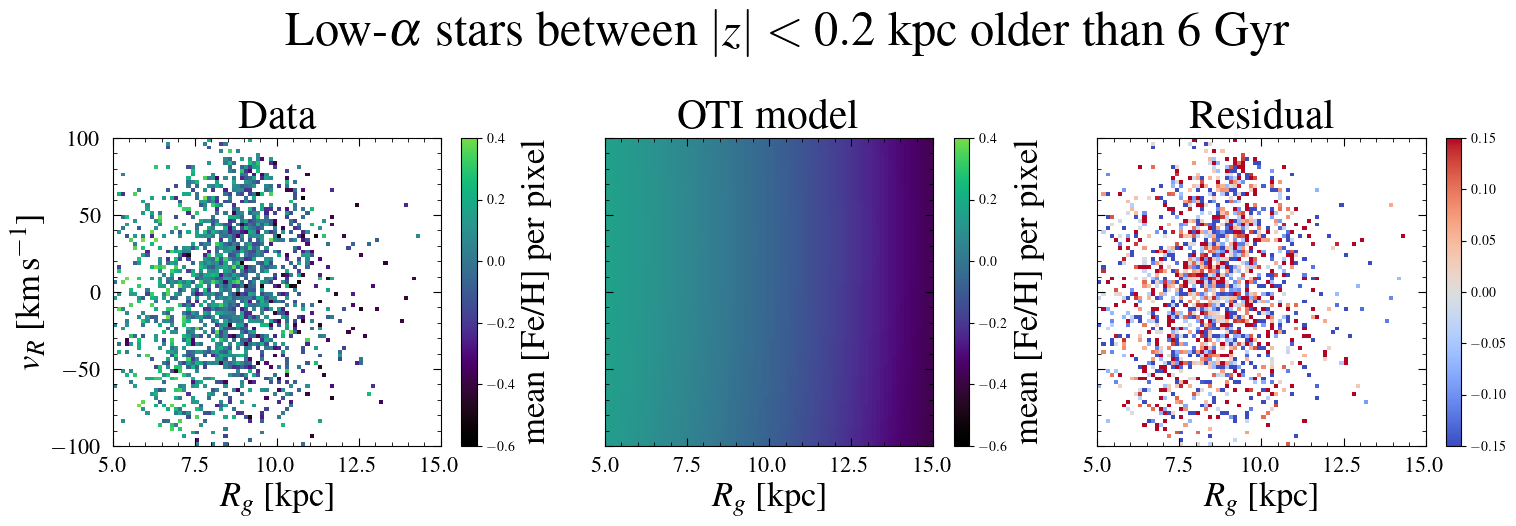

In [116]:
# visualise the data

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
fig.suptitle(r'Low-$\alpha$ stars between $|z|<0.2$ kpc older than 6 Gyr', fontsize=35, y=1.2)

ax = axes[0]
ax.set_title('Data', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"],
    vmin=-0.6,
    vmax=0.4,
    cmap=cm.lavender,
)
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
# ax.set_ylim(-100,100)
ax.set_xlim(0,16)

ax = axes[1]
ax.set_title('OTI model', fontsize=30)
model_H = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    model_H,
    vmin=-0.6,
    vmax=0.4,
    cmap=cm.lavender
)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
# ax.set_ylim(-100,100)
ax.set_xlim(5,15)

ax = axes[2]
ax.set_title('Residual', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"] - model_H,
    vmin=-0.15,
    vmax=0.15,
    cmap='coolwarm'
)

cb = fig.colorbar(cs, ax=ax)
# cb.set_label("Residual")
# ax.set_ylim(-100,100)
ax.set_xlim(5,15)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()

for ax in axes:
    ax.set_xlabel(f"$R_g$ [{u.kpc:latex_inline}]", fontsize=25)
axes[0].set_ylabel(f"$v_R$ [{u.km/u.s:latex_inline}]", fontsize=25)